In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
import pickle

# data
import pandas as pd
import numpy as np

# plotting
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns

# sklearn
from sklearn.preprocessing import scale, StandardScaler

# scipy
import scipy

# displays
from IPython.display import display, clear_output

In [4]:
sys.path = ['/data/mhoffert/tools/ete/'] + sys.path[:-1]
sys.path.append('./../code/')

In [5]:
# custom imports
import gtdb

from ete3 import Tree
from ete3.treeview import faces, AttrFace, TextFace, TreeStyle, NodeStyle, CircleFace, RectFace

In [6]:
import ete3 as ete3
ete3.__version__

'3.1.2'

In [7]:
import os

In [8]:
# for visualizing trees
os.environ['QT_QPA_PLATFORM']='offscreen'

## Outline
Finalized code to make the figure showing the distribution of traits

## Load GTDB data

In [ ]:
%%time
# get gtdb metadata and version containing only phyla with 100+ species
md, md_top_phyla = gtdb.load_gtdb('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv')

Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 7.81 s, sys: 246 ms, total: 8.06 s
Wall time: 8.09 s


In [ ]:
# get a list of the most abundant phyla
most_abundant_phyla = md_top_phyla.groupby(['Phylum']).count().sort_values('accession', ascending=False).head(10)
print(most_abundant_phyla['accession'])

Phylum
Proteobacteria       17350
Bacteroidota          8588
Firmicutes_A          8243
Actinobacteriota      7328
Firmicutes            4216
Patescibacteria       2485
Chloroflexota         1387
Cyanobacteria         1372
Verrucomicrobiota     1325
Planctomycetota       1071
Name: accession, dtype: int64


In [ ]:
md['ncbi_isolation_source'].value_counts()

ncbi_isolation_source
none                                      56895
soil                                        306
biological product [ENVO:02000043]          171
derived from human gut metagenome           156
not provided; submitted under MIGS 2.1      136
                                          ...  
a paper mill waste water polluted pond        1
soil sediment                                 1
grasslands                                    1
soil of a rice field                          1
host s whole body                             1
Name: count, Length: 2026, dtype: int64

## Load trait data

In [12]:
# pca_data = pd.read_csv('./../finalized_data/20241127_trait_data.tsv.gz', 
pca_data = pd.read_csv('./../finalized_data/20250616_trait_data_v2.tsv.gz', 
                       sep='\t', 
                       index_col=0)
pca_data.head()

aerobe  phototroph  autotroph  growth_rate  genome_size  \
GB_GCA_012517545_1  0.012481           0        0.0     3.180542      2358896   
GB_GCA_017540815_1  0.008260           0        0.0     1.161323      3074498   
GB_GCA_001829125_1  0.046911           0        0.0     4.600653      4400620   
GB_GCA_009784515_1  0.081483           0        0.0     5.581473      1826176   
GB_GCA_016936615_1  0.052110           0        0.0     2.326041      3256282   

                    gc_percentage  
GB_GCA_012517545_1      30.427073  
GB_GCA_017540815_1      42.095165  
GB_GCA_001829125_1      26.823927  
GB_GCA_009784515_1      40.947915  
GB_GCA_016936615_1      37.758278

In [13]:
np_pca_data = pd.read_csv('./../finalized_data/20250516_scaled_trait_data_v2.tsv.gz', 
                       sep='\t', 
                       index_col=0)
np_pca_data.head()

aerobe  phototroph  autotroph  growth_rate  genome_size  \
GB_GCA_012517545_1  0.012481         0.0        0.0    -0.120779    -0.637998   
GB_GCA_017540815_1  0.008260         0.0        0.0    -0.867855    -0.264948   
GB_GCA_001829125_1  0.046911         0.0        0.0     0.404638     0.426372   
GB_GCA_009784515_1  0.081483         0.0        0.0     0.767524    -0.915710   
GB_GCA_016936615_1  0.052110         0.0        0.0    -0.436930    -0.170182   

                    gc_percentage  
GB_GCA_012517545_1      -1.708150  
GB_GCA_017540815_1      -0.797864  
GB_GCA_001829125_1      -1.989249  
GB_GCA_009784515_1      -0.887366  
GB_GCA_016936615_1      -1.136206

## Loading GTDB tree

In [14]:
gtdb_full = Tree('/data/mhoffert/genomes/GTDB_r207/tree/bac120_r207.tree', format=1, quoted_node_names=True)

In [15]:
gtdb_full = Tree('/data/mhoffert/fiererlab/periodic_phyla/finalized_data/gtdb_full_tree.nw', format=1, quoted_node_names=True)
gtdb_full.name = 'c000000'

In [16]:
names_map = pd.read_csv('./../finalized_data/gtdb_tree_names_map.tsv.gz', sep='\t', compression='gzip', index_col=0)['0']

In [17]:
gtdb_full.describe()

Number of leaf nodes:	62291
Total number of nodes:	124581
Rooted:	Yes
Most distant node:	RS_GCF_000508245_1
Max. distance:	3.398130


In [18]:
gtdb_pruned = Tree('/data/mhoffert/fiererlab/periodic_phyla/finalized_data/gtdb_pruned_tree.nw', format=1, quoted_node_names=True)
gtdb_pruned.name = 'c000000'

In [19]:
gtdb_pruned.describe()

Number of leaf nodes:	50745
Total number of nodes:	101489
Rooted:	Yes
Most distant node:	RS_GCF_000008205_1
Max. distance:	2.646470


In [20]:
gtdb_pruned.get_children()

[Tree node 'c000001' (0x7fb9bb73b52), Tree node 'c000014' (0x7fb9bb7d5c3)]

In [21]:
top_phyla_clades = pd.read_csv('./../finalized_data/clade2phylum.tsv', sep='\t', index_col=0)['0']

## Load variances explained for wavelets

In [22]:
varexp_ind_df = pd.read_csv('./../finalized_data/waveletcoeffs_var_explained.tsv.gz',
                            index_col=0,
                            sep='\t', compression='gzip')

## Small tree of phyla

In [23]:
from matplotlib import cm

In [24]:
def collapse_tree_phylum(tree): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapse_to_phylum(n), format=3),format=3) 
    t.name = tree.name
    return t

def collapse_to_phylum(node):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    value = False
    leaf_value = False
    if node.is_leaf():
        leaf_value = True
        value = True
    else:
        if 'p__' in names_map.loc[node.name]:
            # print(node.name, names_map.loc[node.name])
            value = True
        else:
            value = False
    # print(node.name, value, leaf_value)
    return value

In [25]:
gtdb_pruned.describe()

Number of leaf nodes:	50745
Total number of nodes:	101489
Rooted:	Yes
Most distant node:	RS_GCF_000008205_1
Max. distance:	2.646470


In [26]:
collapsed_phylum = collapse_tree_phylum(gtdb_pruned)

In [27]:
collapsed_phylum.describe()

Number of leaf nodes:	4507
Total number of nodes:	9013
Rooted:	Yes
Most distant node:	RS_GCF_000008205_1
Max. distance:	2.646470


In [28]:
collapsed_phylum.prune(list(top_phyla_clades.index)) #[c for c in collapsed_phylum.get_leaves() if names_map.loc[c.name].split(':')[-1].split(';')[0].lstrip('p_') in md_top_phyla['Phylum'].unique()], 
                       # preserve_branch_length=True)

In [29]:
collapsed_phylum.describe()

Number of leaf nodes:	31
Total number of nodes:	61
Rooted:	Yes
Most distant node:	c006481
Max. distance:	0.402630


In [511]:
rendered = collapsed_phylum.render('./../figures/phylum_tree_nolabels.svg', tree_style=ts, w=1600, dpi=400)

# Figure 3

## Functions

In [33]:
def spacify_data(labels, arr, space_size, insert_val):
    """
    Inserts `insert_val` into `arr` at group changes in `labels`.

    Parameters:
        labels (array-like): Group labels for `arr`.
        arr (array-like): Input data array.
        space_size (int): Number of `insert_val` to insert at each group change.
        insert_val (any): Value to insert as spacing.

    Returns:
        numpy.ndarray: A single array with spacing values inserted.
    """
    
    # Find the indices where the group changes
    L_array = np.array(labels)
    change_indices = np.where(L_array[:-1] != L_array[1:])[0] + 1

    # Create the values to insert at the change points
    inserts = np.repeat(insert_val, space_size)    
    expanded_indices = np.repeat(change_indices, space_size)

    # Insert the values into N at the appropriate locations
    return np.insert(np.array(arr, dtype=object), expanded_indices, np.repeat(insert_val, len(expanded_indices)))
    
    

In [34]:
def consecutive_counts(arr):
    # Find where the values change
    changes = np.diff(arr, prepend=arr[0]) != 0
    # Assign unique IDs to each consecutive block
    block_ids = np.cumsum(changes)
    # Calculate the counts for each block
    block_counts = np.bincount(block_ids)
    # Map the block counts back to their positions in the original array
    return block_counts[block_ids]

def sliding_window_average_same_length(arr, window_size):
    if window_size > len(arr):
        raise ValueError("Window size must be smaller than or equal to the array size.")
    # Padding the array to handle edge cases
    pad_width = (window_size - 1) // 2
    padded_arr = np.pad(arr, pad_width, mode='edge')  # Pads using edge values
    # Perform the sliding window average
    smoothed = np.convolve(padded_arr, np.ones(window_size) / window_size, mode='valid')
    return smoothed

In [35]:
def check_children(node, trait_data, leaf_locs, node_locs):
    '''
    Function for making sure wavelets and nodes align in plots
    '''
    fig, ax = plt.subplots(figsize=(4, 8))
    
    leaves = get_leaf_names(node)
    left = get_leaf_names(node.get_children()[0])
    x = trait_data.loc[leaves]
    y = leaf_locs.loc[leaves]
    colors = ['blue' if l in left else 'yellow' for l in leaves]
    
    plt.scatter(x, y, s=5, c=colors)
    ax.axhline(node_locs.loc[node.name], color='k')
    

## y-axis plot of phylum labels

In [36]:
# important
postorder_leaves = [i.name for i in gtdb_pruned.traverse(strategy='postorder') if i.is_leaf()]
postorder_nodes = [i.name for i in gtdb_pruned.traverse(strategy='postorder') if not i.is_leaf()]

In [37]:
%%time
phylum_postorder = pd.DataFrame(columns=['mean', 'start', 'stop'])
n_phylum_leaves = pd.Series()
i = 1
for clade, phylum in top_phyla_clades.items():
    display(i)
    clear_output(wait=True)
    # print(clade)
    test_leaves = [l.name for l in gtdb_pruned.search_nodes(name=clade)[0].get_leaves()]
    n_phylum_leaves.loc[clade] = len(test_leaves)
    indeces = [postorder_leaves.index(l) for l in test_leaves]
    phylum_postorder.loc[clade, :] = pd.Series(index=['mean', 'start', 'stop'],
                                                data=[np.mean(indeces), np.min(indeces), np.max(indeces)])
    
    i += 1
    

CPU times: user 34.1 s, sys: 0 ns, total: 34.1 s
Wall time: 34.1 s


In [38]:
postorder_leaf_clades= []
for index, row in phylum_postorder.sort_values('mean').iterrows():
    postorder_leaf_clades += [index] * int(row['stop'] - row['start'] + 1)

In [39]:
# plotting

# import matplotlib.gridspec as gridspec
# from matplotlib.collections import PolyCollection
# import matplotlib.cm as cm
# import matplotlib.patches as patches
from matplotlib.colors import to_hex

done
step1
step3


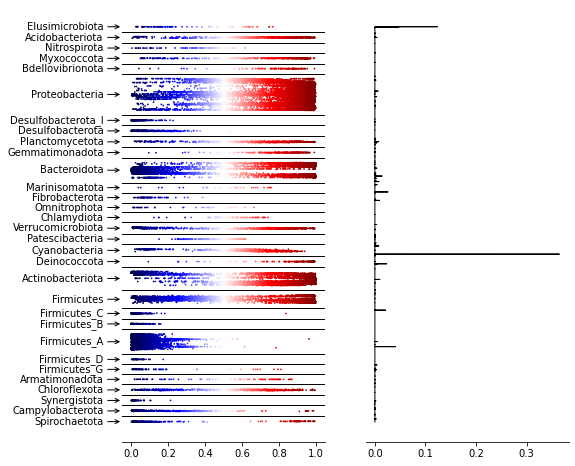

In [41]:
cmap = matplotlib.colormaps['seismic']
# to generate plot identifying a single clade
# colors = [cmap(pca_data.loc[i, 'aerobe']) if i in test_leaves else 'gray' for i in postorder_leaves]
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,2,1)

x = pca_data.reindex(postorder_leaves)['aerobe'].values
y = list(range(len(postorder_leaves)))

space = 5000

new_x, new_c, new_labels = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([x, colors, postorder_leaf_clades],
                                                                                                 [np.nan, 'gray', 'None'])])

new_y = range(len(new_x))

plt.scatter(new_x, new_y,
           s=0.5,
           c=new_c)

temp = np.where(new_labels[:-1] != new_labels[1:])[0] + 1
temp = [temp[i] for i in range(0, len(temp), 2)]

for val in temp:
    ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
my_list_unique = set(phylum_postorder.index)
first_index = pd.Series(dict((x, np.min(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
last_index = pd.Series(dict((x, np.max(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
label_loc = first_index + ((last_index - first_index) / 2).astype(int)

for clade, yloc in label_loc.items():
    ax.annotate(text=top_phyla_clades.loc[clade].split(';')[0].split('__')[-1], xytext=(-0.15, yloc),
                             xy=(-0.05,yloc), arrowprops={'arrowstyle':'->'},
                             annotation_clip=False, va='center', ha='right')
sns.despine()
plt.tick_params(left=False, labelleft=False)
print('done')
## PART 2 ------------------------------------------------------------------------------------
## PART 2 ------------------------------------------------------------------------------------

# ax = phylum_ylabel(ax, stripes=True, label=False)

ax1 = fig.add_subplot(1,2,2)
x = varexp_ind_df.reindex(postorder_nodes)['aerobe'].values
# x = np.log10(x)
y = range(len(x))
# x2 = range(len(y1))
print('step1')
new_x, new_y = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([x, y],
                                                                                                 [np.nan,  np.nan])])

# print('step2')
# xlist = list(zip(new_x1, new_x1))
# ylist = list(zip(new_y1, new_y2))



# new_y = range(len(new_x))

# plt.scatter(new_x, new_y,
#            s=0.5,
#            c=new_c)
print('step3')
# fig, ax = plt.subplots(figsize=(4,6))
# for _x, _y in zip(xlist, ylist):
    # plt.plot(_y, _x, color='k', linewidth=2)
plt.plot(new_x, new_y, color='k', linewidth=1)
    
for val in temp:
    ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
sns.despine()
plt.tick_params(left=False, labelleft=False)

ax.spines['left'].set_visible(False)
ax1.spines['left'].set_visible(False)

## Illustrations of wavelets for high-level clades

done
step1
step3


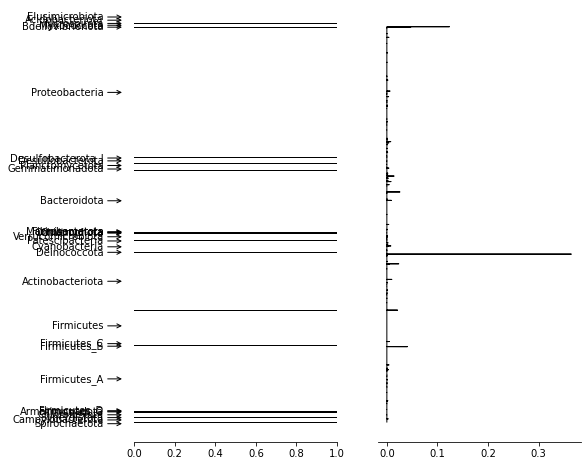

In [42]:
cmap = matplotlib.colormaps['seismic']
# to generate plot identifying a single clade
# colors = [cmap(pca_data.loc[i, 'aerobe']) if i in test_leaves else 'gray' for i in postorder_leaves]
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,2,1)

x = pca_data.reindex(postorder_leaves)['aerobe'].values
y = list(range(len(postorder_leaves)))

space = 0

new_x, new_c, new_labels = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([x, colors, postorder_leaf_clades],
                                                                                                 [np.nan, 'gray', 'None'])])

new_y = range(len(new_x))

# plt.scatter(new_x, new_y,
#            s=0.5,
#            c=new_c)

temp = np.where(new_labels[:-1] != new_labels[1:])[0] + 1
temp = [temp[i] for i in range(0, len(temp), 2)]

for val in temp:
    ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
my_list_unique = set(phylum_postorder.index)
first_index = pd.Series(dict((x, np.min(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
last_index = pd.Series(dict((x, np.max(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
label_loc = first_index + ((last_index - first_index) / 2).astype(int)

for clade, yloc in label_loc.items():
    ax.annotate(text=top_phyla_clades.loc[clade].split(';')[0].split('__')[-1], xytext=(-0.15, yloc),
                             xy=(-0.05,yloc), arrowprops={'arrowstyle':'->'},
                             annotation_clip=False, va='center', ha='right')
sns.despine()
plt.tick_params(left=False, labelleft=False)
print('done')
## PART 2 ------------------------------------------------------------------------------------
## PART 2 ------------------------------------------------------------------------------------

# ax = phylum_ylabel(ax, stripes=True, label=False)

ax1 = fig.add_subplot(1,2,2)
x = varexp_ind_df.reindex(postorder_nodes)['aerobe'].values
# x = np.log10(x)
y = range(len(x))
# x2 = range(len(y1))
print('step1')
new_x, new_y = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([x, y],
                                                                                                 [np.nan,  np.nan])])
new_x = new_x.astype(float)

# print('step2')
# xlist = list(zip(new_x1, new_x1))
# ylist = list(zip(new_y1, new_y2))



# new_y = range(len(new_x))

# plt.scatter(new_x, new_y,
#            s=0.5,
#            c=new_c)
print('step3')
# fig, ax = plt.subplots(figsize=(4,6))
# for _x, _y in zip(xlist, ylist):
    # plt.plot(_y, _x, color='k', linewidth=2)
plt.plot(new_x, new_y, color='k', linewidth=1)
    
for val in temp:
    ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
sns.despine()
plt.tick_params(left=False, labelleft=False)

ax.spines['left'].set_visible(False)
ax1.spines['left'].set_visible(False)

# plt.savefig('./../figures/wt_aerobe_phylum_labels_nodata.svg', bbox_inches='tight', transparent=True)
# plt.savefig('./../figures/wt_aerobe_phylum_labels_nodata.png', bbox_inches='tight', dpi=400, transparent=True)

### Calculating node xlocs
for equal left/right distribution of nodes

In [43]:
leaf_locs = pd.Series(index=postorder_leaves, data=list(range(1, len(postorder_leaves)+1)))

In [44]:
get_leaf_names = lambda node: [l.name for l in node.get_leaves()]

node_xlocs = pd.Series()
for count, i in enumerate(gtdb_pruned.traverse()):
    if count % 500 == 0:
        display(count)
        clear_output(wait=True)
    if not i.is_leaf():
        left = leaf_locs.loc[get_leaf_names(i.get_children()[0])].max()
        right = leaf_locs.loc[get_leaf_names(i.get_children()[1])].min()
        node_xlocs.loc[i.name] = (left + right) / 2

101000

In [45]:
po_leaf_series = pd.Series(index=postorder_leaves, data=range(len(postorder_leaves)))

### Calculating taxon dists from root

In [46]:
# measure distances from named nodes to root
taxon_dists = pd.Series()
for i, node in enumerate(gtdb_pruned.traverse()):
    if i % 1000 == 0:
        display(i)
        clear_output(wait=True)
        
    if '__' in names_map.loc[node.name]:
        taxon_dists.loc[node.name] = gtdb_pruned.get_distance(node)

101000

In [47]:
taxon_dist_df = pd.merge(taxon_dists.rename('dist'), names_map, left_index=True, right_index=True)

In [48]:
taxon_dist_df['level'] = taxon_dist_df['0'].apply(lambda x: x.split(':')[-1].split('__')[0])

In [49]:
taxon_dist_df['level'].unique()

array(['d', 'p', 'c', 'o', 'g', 'f'], dtype=object)

## Combined plot

In [51]:
def make_phylum_labels(ax, n_bins=40, expand=1.1):
    """
    Unsafe function: contains global namespace elements
    """

    # draw labels
    # list of phyla
    my_list_unique = list((phylum_postorder['start'] - phylum_postorder['stop']).apply(np.abs).sort_values(ascending=False).index.unique())
    first_index = pd.Series(dict((x, np.min(np.nonzero(labels == x)[0])) for x in my_list_unique))
    last_index = pd.Series(dict((x, np.max(np.nonzero(labels == x)[0])) for x in my_list_unique))
    # set label locations in between top and bottom leaf
    label_loc = first_index + ((last_index - first_index) / 2).astype(int)

    # adjust placement of labels so that they don't overlap
    n_bins = 40
    ylocs = sorted([l[1] for l in label_loc.items()])
    yloc_bins = assign_bins_greedy(ylocs, n_bins)
    bin_centers = compute_bin_centers(ylocs, n_bins, expand=1.1)
    new_ylocs = [bin_centers[yloc_bins[y]] for y in ylocs]

    for (clade, yloc), text_yloc in zip(label_loc.sort_values().items(), new_ylocs):
        t = ax.annotate(text=top_phyla_clades.loc[clade].split(';')[0].split('__')[-1], xy=(-0.15, text_yloc),
                                 # xy=(-0.05, yloc), arrowprops={'arrowstyle':'->'},
                                 annotation_clip=False,
                        va='center', ha='right')
        plt.arrow(x=-0.1, y=text_yloc, dx=0.10, dy=yloc - text_yloc)


    sns.despine(left=True)
    plt.tick_params(left=False, labelleft=False)
    ax.set_xticks(np.linspace(0, 1, 3))



In [52]:


def compute_bin_centers(A, N, expand=1):
    A_min, A_max = min(A), max(A)  # Get min and max of A
    A_range = (A_max - A_min) * expand
    middle = A_min + ((A_min + A_max) / 2)
    start = middle - A_range / 2
    stop = middle + A_range / 2
    bin_edges = np.linspace(start, stop, N + 1)  # Compute bin edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute centers as midpoints
    
    return bin_centers


def assign_bins_greedy(A, N):
    A = np.array(A)  # Convert to array

    # Compute target quantile-based bin locations
    bins = np.linspace(0, 1, N+1) * max(A)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute centers as midpoints

    # Available bins
    available_bins = set(range(N))
    assignment = {}

    for a in A:
        closest_bin = list(available_bins)[np.argmin(np.abs(a - bin_centers[list(available_bins)]))]
        assignment[a] = closest_bin
        available_bins.remove(closest_bin)  # Remove assigned bin

    return assignment


In [54]:
SAVE_DATA = True

50745
50745


Text(0.5, 0.95, 'F')

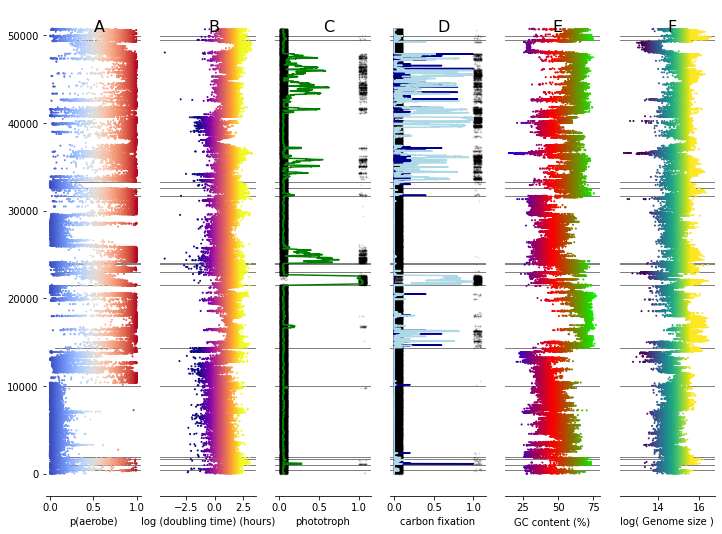

In [55]:
fig = plt.figure(figsize=(12, 9))

y = list(range(len(postorder_leaves)))

# get locations of separating lines
labels = np.array(postorder_leaf_clades)
temp = np.where(labels[:-1] != labels[1:])[0] + 1
temp = [temp[i] for i in range(0, len(temp), 2)]


### ------------------------------------------
# probability of being aerobic
### ------------------------------------------

ax1 = fig.add_subplot(1, 6, 1)

x = pca_data.reindex(postorder_leaves)['aerobe'].values
cmap = matplotlib.colormaps['coolwarm']
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]

plt.scatter(x, y, c=colors,
            s=1)

for val in temp:
    ax1.axhline(val+int(space / 2), xmin=0.1, xmax=1, linewidth=1, color='gray', zorder=0)

ax1.set_xlabel('p(aerobe)')

# make_phylum_labels(ax1, 40, 1.1)

ax1.annotate('A', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

### ------------------------------------------
# growth rate
### ------------------------------------------

ax = fig.add_subplot(1, 6, 2, sharey=ax1)

norm = mpl.colors.Normalize(vmin=-2,
                            vmax=pca_data['growth_rate'].apply(np.log).max())

x = pca_data.reindex(postorder_leaves)['growth_rate'].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['plasma']
colors = [to_hex(cmap(norm(np.log2(pca_data.loc[i, 'growth_rate'])))) for i in postorder_leaves]

plt.scatter(x, y, c=colors,
            s=1)

for val in temp:
    ax.axhline(val+int(space / 2), xmin=0, xmax=1, linewidth=1, color='gray', zorder=0)

ax.set_xlabel('log (doubling time) (hours)')

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

ax.annotate('B', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')


### ------------------------------------------
# phototrophy
### ------------------------------------------

ax = fig.add_subplot(1, 6, 3, sharey=ax1)

x = pca_data.reindex(postorder_leaves)['phototroph'].values + (np.random.random(len(postorder_leaves)) / 10)
y = list(range(len(postorder_leaves)))

plt.scatter(x, y, c='k',
            s=1, alpha=0.1)

# plot sliding average line
window_size = 151
line_x = sliding_window_average_same_length(x, #pca_data.reindex(postorder_leaves)['phototroph'].values, 
                                            window_size) #np.convolve(x, np.ones(window_size) / window_size, mode='valid')

plt.plot(line_x, y, c='green')

for val in temp:
    ax.axhline(val+int(space / 2), xmin=0, xmax=1, linewidth=1, color='gray', zorder=0)

ax.set_xlabel('phototroph')

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

ax.annotate('C', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')


### ------------------------------------------
# Carbon fixation
### ------------------------------------------

ax = fig.add_subplot(1, 6, 4, sharey=ax1)

# aggregation of carbon fixation trait
carbon_sum = (pca_data[['3HP bicycle', 'Calvin Cycle']].sum(1) > 0).astype(int)
x = carbon_sum.reindex(postorder_leaves).values + (np.random.random(len(postorder_leaves)) / 10)

y = list(range(len(postorder_leaves)))

plt.scatter(x, y, c='k',
            s=1, alpha=0.1)

# plot sliding average line
for cycle, _c, window_size in zip(['3HP bicycle', 'Calvin Cycle'],
                     ['darkblue', 'lightblue'],
                     [5, 50]):
    x = pca_data.reindex(postorder_leaves)[cycle].values
    line_x = sliding_window_average_same_length(x,
                                                window_size)
    
    if len(line_x) < len(y):
        line_x = np.append(line_x, [0])
    print(len(line_x))
    
    plt.plot(line_x, y, c=_c)
    
for val in temp:
    ax.axhline(val+int(space / 2), xmin=0, xmax=1, linewidth=1, color='gray', zorder=0)

ax.set_xlabel('carbon fixation')

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

ax.annotate('D', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')


### ------------------------------------------
# GC content
### ------------------------------------------

ax = fig.add_subplot(1,6,5, sharey=ax1)

norm = mpl.colors.Normalize(vmin=pca_data['gc_percentage'].min(),
                            vmax=pca_data['gc_percentage'].max())

x = pca_data.reindex(postorder_leaves)['gc_percentage'].values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['brg']
colors = [to_hex(cmap(norm(pca_data.loc[i, 'gc_percentage']))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)

for val in temp:
    ax.axhline(val+int(space / 2), xmin=-0.1, xmax=1.1, linewidth=1, color='gray', zorder=0)


ax.set_xlabel('GC content (%)')

plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

ax.annotate('E', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')


### ------------------------------------------
# Genome size
### ------------------------------------------

ax = fig.add_subplot(1, 6, 6, sharey=ax1)

norm = mpl.colors.Normalize(vmin=pca_data['genome_size'].apply(np.log).min()+1,
                            vmax=pca_data['genome_size'].apply(np.log).max()-1)

x = pca_data.reindex(postorder_leaves)['genome_size'].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['viridis']
colors = [to_hex(cmap(norm(np.log(pca_data.loc[i, 'genome_size'])))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)

for val in temp:
    ax.axhline(val+int(space / 2), xmin=0, xmax=1, linewidth=1, color='gray', zorder=0)

    
ax.set_xlabel('log( Genome size )')
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

### ------------------------------------------
# SAVE
### ------------------------------------------

ax.annotate('F', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

# plt.savefig('./../figures/haar_method/trait_data_summary_fig.svg', bbox_inches='tight')
# plt.savefig('./../figures/haar_method/trait_data_summary_fig.png', 
#             bbox_inches='tight', dpi=400)

## Combined wavelet plot

In [56]:
def get_treeplot_bounds(trait, n=10):
    
    # get the ten largest wavelets for this trait
    n_largest = varexp_ind_df.loc[:, trait].sort_values(ascending=False).head(n)
    
    # get the bounds of the clades for each wavelet
    # xs: location of wavelet from root
    # ys: upper and lower limit of children's leaf locaiton, in postorder
    # provide bounds for a box to superimpose on postordered leaves, delineating clades
    treeplot_xs, treeplot_ys = [], []
    count = n
    clade_ys = []
    for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
        if not _node.is_leaf() and _node.name in n_largest.index:
            ymin, ymax = po_leaf_series.loc[[l.name for l in _node.get_leaves()]].aggregate(['min', 'max'])
            clade_ys += [ymin, ymax]
            for node in _node.get_children():
                ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
                treeplot_ys.append([ymin, ymax])
                treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
            count -= 1
            
    # reverse for the purposes of plotting
    # plot largest clades first ... ? 
    treeplot_xs = treeplot_xs[::-1]
    treeplot_ys = treeplot_ys[::-1]
    
    # get set of distances from root to largest clades
    hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))
    
    # get maximum distance, for setting axis bounds
    xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])
    
    return treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax

In [57]:
SAVE_DATA = True

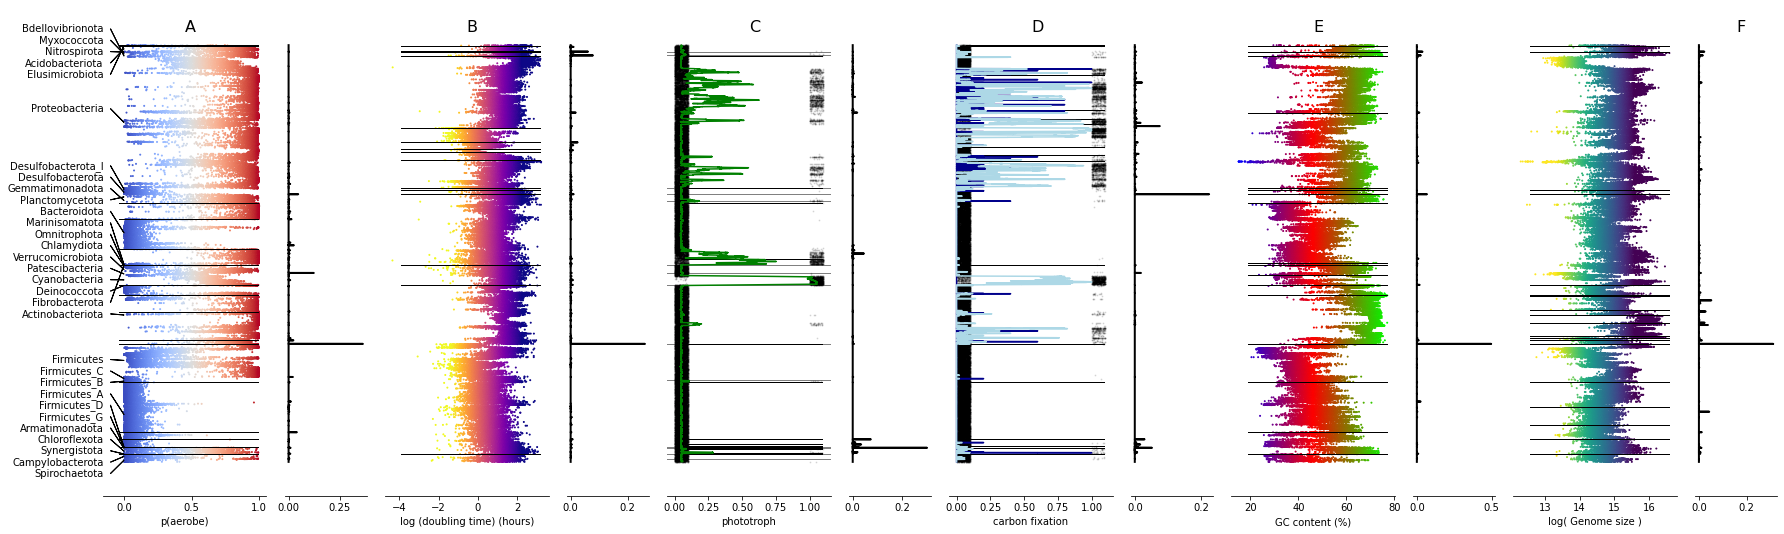

In [58]:
fig = plt.figure(figsize=(30, 9))
gs = fig.add_gridspec(1, 12, width_ratios=[2,1,2,1,2,1,2,1,2,1,2,1])

y = list(range(len(postorder_leaves)))

# get locations of separating lines
labels = np.array(postorder_leaf_clades)
temp = np.where(labels[:-1] != labels[1:])[0] + 1
temp = [temp[i] for i in range(0, len(temp), 2)]

### ------------------------------------------
# probability of being aerobic
### ------------------------------------------

trait = 'aerobe'

# ax1 = fig.add_subplot(1, 12, 1)
ax1 = fig.add_subplot(gs[0])

if SAVE_DATA:
    x = pca_data.reindex(postorder_leaves)[trait].values
    cmap = matplotlib.colormaps['coolwarm']
    colors = [to_hex(cmap(pca_data.loc[i, trait])) for i in postorder_leaves]
    plt.scatter(x, y, c=colors,
            s=1)

ax1.set_xlabel('p(aerobe)')
ax1.annotate('A', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

make_phylum_labels(ax1, 40, 1.1)

sns.despine(left=True)

# ax = fig.add_subplot(1, 12, 2, sharey=ax1)
ax = fig.add_subplot(gs[1], sharey=ax1)

treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds(trait, 10)

for item in clade_ys:
    
    ax1.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

# ### ------------------------------------------
# # growth rate
# ### ------------------------------------------

trait = 'growth_rate'

treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds(trait, 10)

# ax = fig.add_subplot(1, 12, 3, sharey=ax1)
ax = fig.add_subplot(gs[2], sharey=ax1)

norm = mpl.colors.Normalize(vmin=-2,
                            vmax=pca_data[trait].apply(np.log).max())

x = pca_data.reindex(postorder_leaves)[trait].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['plasma_r']
colors = [to_hex(cmap(norm(np.log2(pca_data.loc[i, trait])))) for i in postorder_leaves]

plt.scatter(x, y, c=colors,
            s=1)

for item in clade_ys:
    ax.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)

ax.set_xlabel('log (doubling time) (hours)')
ax.annotate('B', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

### --------- Haar wavelet

# ax = fig.add_subplot(1, 12, 4, sharey=ax1)
ax = fig.add_subplot(gs[3], sharey=ax1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

### ------------------------------------------
# phototrophy
### ------------------------------------------

trait = 'phototroph'
treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds(trait, 10)

# ax = fig.add_subplot(1, 12, 5, sharey=ax1)
ax = fig.add_subplot(gs[4], sharey=ax1)

x = pca_data.reindex(postorder_leaves)[trait].values + (np.random.random(len(postorder_leaves)) / 10)
y = list(range(len(postorder_leaves)))

plt.scatter(x, y, c='k',
            s=1, alpha=0.1)

for item in clade_ys:
    ax.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)

# plot sliding average line
window_size = 151
line_x = sliding_window_average_same_length(x, #pca_data.reindex(postorder_leaves)['phototroph'].values, 
                                            window_size) #np.convolve(x, np.ones(window_size) / window_size, mode='valid')

plt.plot(line_x, y, c='green')

for val in temp:
    ax.axhline(val+int(space / 2), xmin=0, xmax=1, linewidth=1, color='gray', zorder=0)

ax.set_xlabel(trait)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

ax.annotate('C', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

## haar wavelet ------------------------------------------------------------

# ax = fig.add_subplot(1, 12, 6, sharey=ax1)
ax = fig.add_subplot(gs[5], sharey=ax1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

### ------------------------------------------
# Carbon fixation
### ------------------------------------------

trait = 'Calvin Cycle'

# aggregation of carbon fixation trait
carbon_sum = (pca_data[['3HP bicycle', 'Calvin Cycle']].sum(1) > 0).astype(int)
x = carbon_sum.reindex(postorder_leaves).values + (np.random.random(len(postorder_leaves)) / 10)

# ax = fig.add_subplot(1, 12, 7, sharey=ax1)
ax = fig.add_subplot(gs[6], sharey=ax1)

treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds('Calvin Cycle', 10)

for item in clade_ys:
    
    ax.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)

y = list(range(len(postorder_leaves)))

plt.scatter(x, y, c='k',
            s=1, alpha=0.1)

# plot sliding average line
for cycle, _c, window_size in zip(['3HP bicycle', 'Calvin Cycle'],
                     ['darkblue', 'lightblue'],
                     [5, 50]):
    x = pca_data.reindex(postorder_leaves)[cycle].values
    line_x = sliding_window_average_same_length(x,
                                                window_size)
    
    if len(line_x) < len(y):
        line_x = np.append(line_x, [0])
    
    plt.plot(line_x, y, c=_c)

ax.set_xlabel('carbon fixation')

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

ax.annotate('D', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

# Haar wavelet -------------------------------------------- 

# ax = fig.add_subplot(1, 12, 8, sharey=ax1)
ax = fig.add_subplot(gs[7], sharey=ax1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

# ### ------------------------------------------
# # GC content
# ### ------------------------------------------
trait = 'gc_percentage'

# ax = fig.add_subplot(1, 12, 9, sharey=ax1)
ax = fig.add_subplot(gs[8], sharey=ax1)

treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds(trait, 10)

for item in clade_ys:
    ax.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)
    
norm = mpl.colors.Normalize(vmin=pca_data[trait].min(),
                            vmax=pca_data[trait].max())

x = pca_data.reindex(postorder_leaves)[trait].values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['brg']
colors = [to_hex(cmap(norm(pca_data.loc[i, trait]))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)

ax.set_xlabel('GC content (%)')

plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

ax.annotate('E', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

# haar-wavelet -------------------------------------------------------------------

# ax = fig.add_subplot(1, 12, 10, sharey=ax1)
ax = fig.add_subplot(gs[9], sharey=ax1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

### ------------------------------------------
# Genome size
### ------------------------------------------
trait = 'genome_size'
# ax = fig.add_subplot(1, 12, 11, sharey=ax1)
ax = fig.add_subplot(gs[10], sharey=ax1)

treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds(trait, 10)

for item in clade_ys:
    ax.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)

norm = mpl.colors.Normalize(vmin=pca_data[trait].apply(np.log).min()+1,
                            vmax=pca_data[trait].apply(np.log).max()-1)

x = pca_data.reindex(postorder_leaves)[trait].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['viridis_r']
colors = [to_hex(cmap(norm(np.log(pca_data.loc[i, trait])))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)
    
ax.set_xlabel('log( Genome size )')
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

# haar-wavelet -------------------------------------------------------------------

# ax = fig.add_subplot(1, 12, 12, sharey=ax1)
ax = fig.add_subplot(gs[11], sharey=ax1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)

# ### ------------------------------------------
# # SAVE
# ### ------------------------------------------

fig.subplots_adjust(wspace=0.15)

ax.annotate('F', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

# plt.savefig('./../figures/haar_method/wavelet_data_summary_fig.svg', bbox_inches='tight')
plt.savefig('./../figures/haar_method/wavelet_data_summary_fig.png', 
            bbox_inches='tight', dpi=400)

## Trying to emphasize both wavlet-based and phylum-level splits

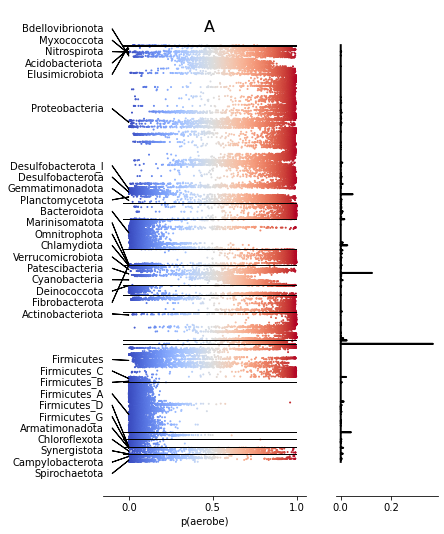

In [62]:
fig = plt.figure(figsize=(6, 9))
gs = fig.add_gridspec(1, 2, width_ratios=[2,1])

y = list(range(len(postorder_leaves)))

# get locations of separating lines
labels = np.array(postorder_leaf_clades)
temp = np.where(labels[:-1] != labels[1:])[0] + 1
temp = [temp[i] for i in range(0, len(temp), 2)]

### ------------------------------------------
# probability of being aerobic
### ------------------------------------------

trait = 'aerobe'

# ax1 = fig.add_subplot(1, 12, 1)
ax1 = fig.add_subplot(gs[0])

if SAVE_DATA:
    x = pca_data.reindex(postorder_leaves)[trait].values
    cmap = matplotlib.colormaps['coolwarm']
    colors = [to_hex(cmap(pca_data.loc[i, trait])) for i in postorder_leaves]
    plt.scatter(x, y, c=colors,
            s=1)

ax1.set_xlabel('p(aerobe)')
ax1.annotate('A', xy=(0.5, 0.95), fontsize=16, xycoords='axes fraction')

make_phylum_labels(ax1, 40, 1.1)

sns.despine(left=True)

# ax = fig.add_subplot(1, 12, 2, sharey=ax1)
ax = fig.add_subplot(gs[1], sharey=ax1)

treeplot_xs, treeplot_ys, clade_ys, hash_values, xmax = get_treeplot_bounds(trait, 10)

for item in clade_ys:
    
    ax1.axhline(item, xmin=0.1, xmax=0.95, color='k', linewidth=1, alpha=1)

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, trait].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

sns.despine(left=True)
plt.tick_params(left=False, labelleft=False)


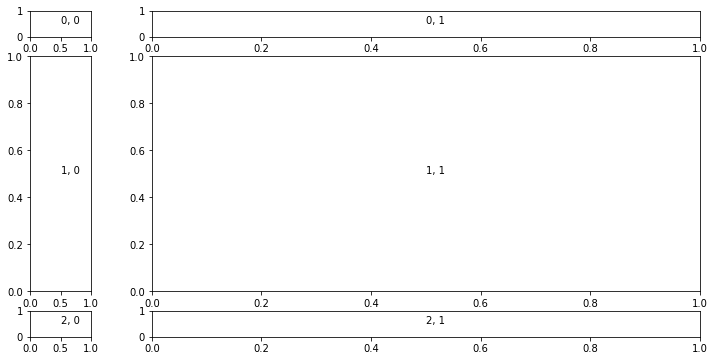

In [91]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 9], height_ratios=[1,9,1])

axes = []
for i in range(3):
    for j in range(2):
        axes.append(fig.add_subplot(gs[i, j]))
        axes[-1].annotate(f'{i}, {j}', (0.5,0.5))

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 9], height_ratios=[1,9,1])

axes = []
for i in range(3):
    for j in range(2):
        axes.append(fig.add_subplot(gs[i, j]))
        axes[-1].annotate(f'{i}, {j}', (0.5,0.5))

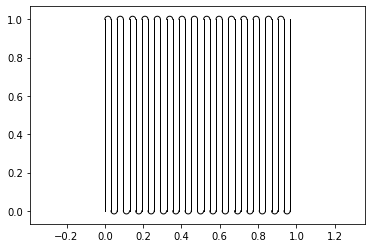

In [87]:
def generate_path(N):
    segments = []
    r = 1 / (2 * N)
    theta = np.linspace(0, np.pi, 20)
    
    for i in range(N):
        x_straight = [i / N, i / N]
        y_straight = [1, 0] if i % 2 == 0 else [0, 1]
        segments.append((x_straight, y_straight))
        
    for i in range(N-1):
        cx, cy = (i / N) + r, 1 if i % 2 == 0 else 0
        x_curve = cx + r * np.cos(theta if i % 2 == 0 else -theta)
        y_curve = cy + r * np.sin(theta if i % 2 == 0 else -theta)
        segments.append((x_curve, y_curve))
    
    return segments

def plot_path(N):
    segments = generate_path(N)
    for x, y in segments:
        plt.plot(x, y, 'k-', lw=1)
    plt.axis("equal")
    plt.show()

plot_path(31)

In [112]:
print(traits)

['aerobe', 'gc_percentage']


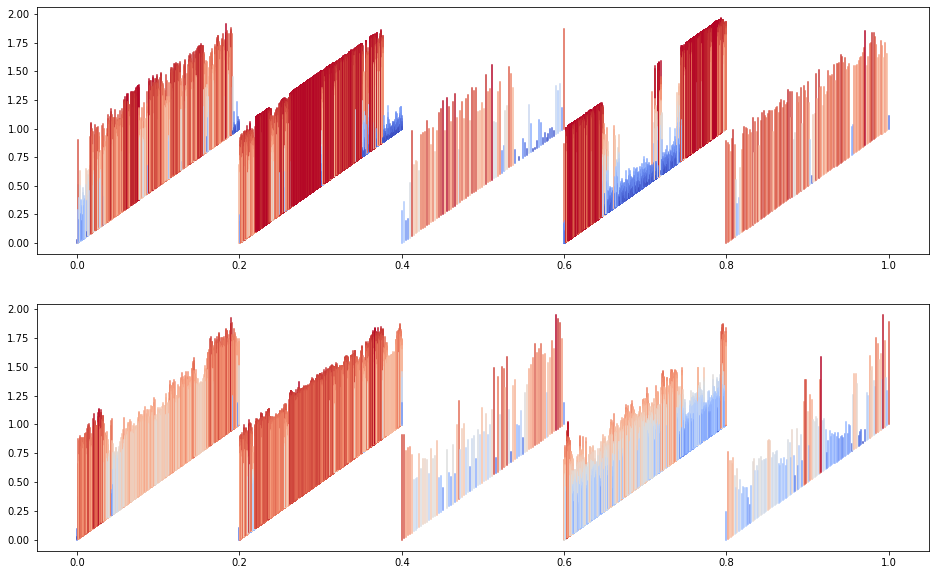

In [143]:
traits = ['aerobe', 'gc_percentage']# , 'growth_rate', 'Calvin Cycle', 'phototroph', 'genome_size']
fig, axes = plt.subplots(len(traits), 1, figsize=(16, 10))
data = np.random.random(n_points)

for big_i, ax in enumerate(axes.flatten()):
    
    curr = 0
    ls = np.linspace(0, 1, 5+1)
    for j, clade in enumerate(top_phyla_clades.head().index):
        display(j)
        clear_output(wait=True)
        node = gtdb_pruned.search_nodes(name=clade)[0]
        leaves = get_leaf_names(node)
        
        n_points = len(node.get_leaves())
        x = np.linspace(ls[j], ls[j+1], n_points) #np.linspace(0, ls[curr+n_points]-ls[curr], n_points)
        raw = pca_data.loc[leaves, traits[big_i]]
        _min, _max = raw.min(), raw.max()
        norm = mpl.colors.Normalize(_min, _max)
        data = raw.apply(norm)
        cmap = mpl.colormaps['coolwarm']
        colors = data.apply(cmap)
        ys = np.linspace(0, 1, n_points)
        for i in range(n_points):
            ax.plot((x[i], x[i]), 
                    (ys[i], ys[i]+data.iloc[i]),
                   c=colors.iloc[i])
            
        curr += n_points

In [150]:
from matplotlib.collections import LineCollection
import warnings

In [211]:
def colored_line_between_pts(x, y, c, ax, **lc_kwargs):
    if isinstance(c, str):
        # If a single color is provided, apply it to all segments
        c = [c] * (len(x) - 1)
    
    # Create a set of line segments so that we can color them individually
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create the LineCollection
    lc = LineCollection(segments, **lc_kwargs)
    
    # Set the color for each segment
    lc.set_color(c)
    
    # Add collection to the plot
    return ax.add_collection(lc)

In [253]:
phylum_postorder.sort_values('start')

mean    start     stop
c000001    204.5      0.0    409.0
c000178    669.0    410.0    928.0
c000123    961.5    929.0    994.0
c000596   1311.0    995.0   1627.0
c000837   1669.5   1628.0   1711.0
c000591   1749.5   1712.0   1787.0
c001524   1812.5   1788.0   1837.0
c002663   5768.0   1838.0   9698.0
c002049   9825.0   9699.0   9951.0
c002050  10144.0   9952.0  10336.0
c001522  12351.0  10337.0  14365.0
c000286  17889.5  14366.0  21413.0
c000420  21483.5  21414.0  21553.0
c000191  22168.0  21554.0  22782.0
c000127  22893.5  22783.0  23004.0
c000639  23415.5  23005.0  23826.0
c001220  23871.5  23827.0  23916.0
c000643  23935.5  23917.0  23954.0
c002263  23988.0  23955.0  24021.0
c003851  24037.0  24022.0  24052.0
c004954  27884.0  24053.0  31715.0
c002275  31827.0  31716.0  31938.0
c000908  32266.0  31939.0  32593.0
c001721  32838.0  32594.0  33082.0
c009808  33193.0  33083.0  33303.0
c006481  41341.5  33304.0  49379.0
c006484  49439.0  49380.0  49498.0
c003967  49678.0  49499.0  49857.0
c003015  49904.0  49858.0  49950.0
c000911  50305.5  49951.0  50660.0
c000869  50702.5  50661.0  50744.0

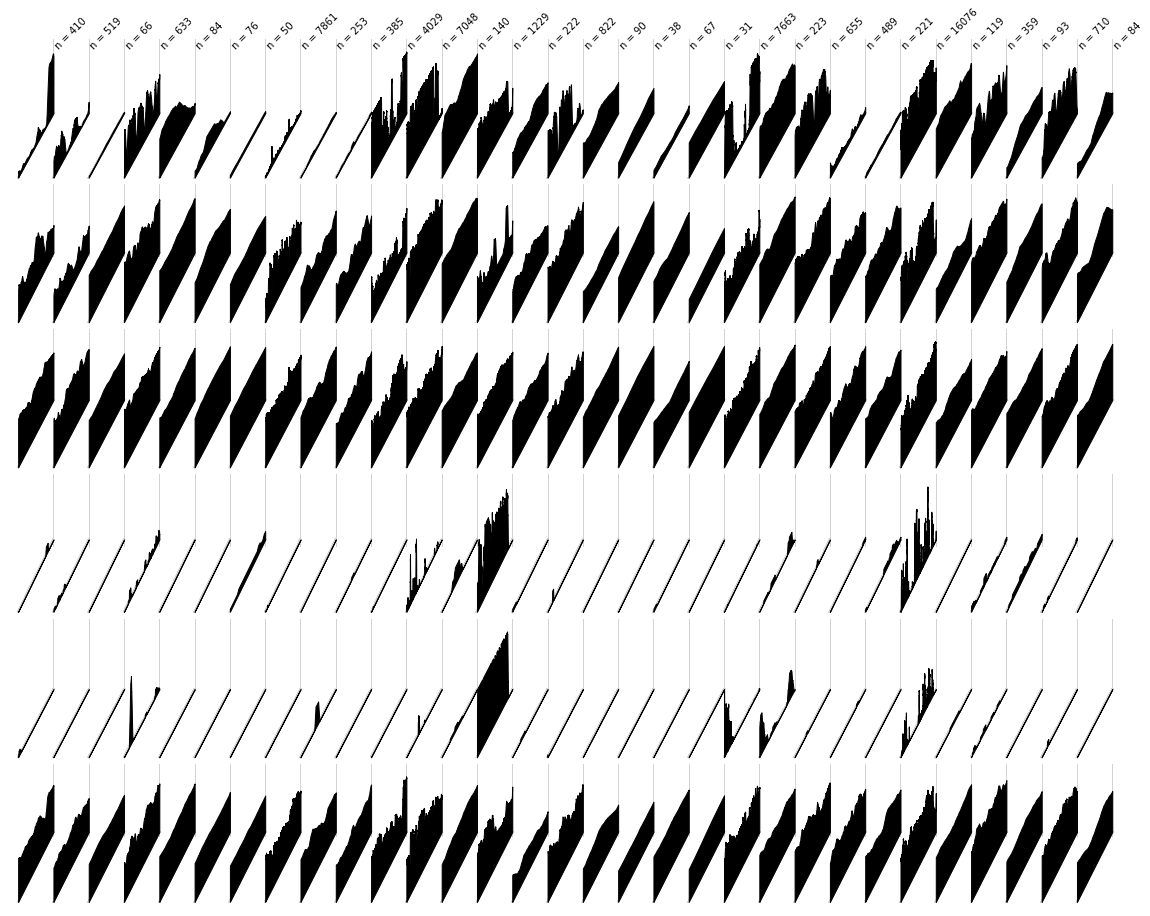

In [256]:
traits = ['aerobe', 'gc_percentage' , 'growth_rate', 'Calvin Cycle', 'phototroph', 'genome_size']
cmaps = ['coolwarm', 'brg', 'plasma_r', 'YlGnBu', 'YlGn', 'viridis_r']
log = [False, False, True, False, False, True]

fig, axes = plt.subplots(len(traits), 1, figsize=(20, 16))
data = np.random.random(n_points)

if isinstance(axes, np.ndarray):
    enum = enumerate(axes.flatten())
else:
    enum = enumerate([axes])
    
for big_i, ax in enum:
    
    curr = 0
    run_for = phylum_postorder.sort_values('start')
    ls = np.linspace(0, 1, len(run_for)+1)
    maxes = []
    for j, clade in enumerate(run_for.index):
        display(big_i, j)
        clear_output(wait=True)
        node = gtdb_pruned.search_nodes(name=clade)[0]
        leaves = get_leaf_names(node)
        
        n_points = len(node.get_leaves())
        ws = np.max([25, int(n_points / 100)])
        #np.linspace(0, ls[curr+n_points]-ls[curr], n_points)
        raw = pca_data.loc[leaves, traits[big_i]]
        x = np.linspace(ls[j], ls[j+1], len(raw)-ws+1)
        _min, _max = pca_data[traits[big_i]].min(), pca_data[traits[big_i]].max()
        
        if log[big_i]:
            raw = raw.apply(np.log10)  
            _min, _max = pca_data[traits[big_i]].apply(np.log10).min(), pca_data[traits[big_i]].apply(np.log10).max()
            
        norm = mpl.colors.Normalize(_min, _max)
        data = np.lib.stride_tricks.sliding_window_view(raw.apply(norm), window_shape = (ws, )).mean(1) 
        
        cmap = mpl.colormaps[cmaps[big_i]]
        colors = [tuple(c) for c in cmap(data)][:-1]

        ys = np.linspace(0, 1, len(data)) #n_points)
        new_x = [x[i] for i in range(len(data))]
        new_y = [ys[i]+data[i] for i in range(len(data))]
        
        ax.fill_between(new_x, ys, new_y, color='k') #cmap(data.mean()), alpha=0.5, zorder=1)
        # colored_line_between_pts(new_x, new_y, c=colors, ax=ax, **{'linewidth':5, 'zorder':2})
    
        ax.axvline(np.max(new_x), 0.5, 1, linewidth=1, color='lightgray', zorder=0)
        if big_i == 0:
            ax.annotate(f'n = {n_points}', (np.max(new_x), 2), rotation=45)
            
        # ax.axhline(0, color='lightgray', zorder=0)
        
        for l in range(len(ls)-1):
            ax.plot((ls[l], ls[l+1]), (0, 1), color='lightgray', zorder=0)
        

            
        maxes.append(np.max(new_y))
        
    ax.set_ylim(-0.1, np.max(maxes) * 1.1)
    ax.set_xlim(-0.01, 1.01)
    
    sns.despine(bottom=True, left=True, ax=ax)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
fig.subplots_adjust(hspace=0)

## barplot-style

In [40]:
from collections import Counter

In [41]:
import matplotlib.patches as patches

In [42]:
def assign_spots(N, businesses, expected_customers):
    B = len(businesses)
    
    # Step 1: Give each business at least 1 spot
    base_allocation = np.ones(B, dtype=int)
    remaining_spots = N - B  # Remaining spots to distribute
    
    # Step 2: Compute adjusted quotas for remaining spots
    total_customers = sum(expected_customers)
    quotas = (np.array(expected_customers) / total_customers) * remaining_spots
    
    # Step 3: Allocate floor(quotas) spots
    allocation = base_allocation + np.floor(quotas).astype(int)
    remaining_spots -= allocation.sum() - B  # Adjust remaining spots
    
    # Step 4: Assign leftover spots using largest remainders
    remainders = quotas - np.floor(quotas)
    extra_spots = np.argsort(remainders)[-remaining_spots:]  # Businesses with highest remainders
    for i in extra_spots:
        allocation[i] += 1

    # Step 5: Convert allocation to final spot assignments
    assignments = []
    for biz, count in zip(businesses, allocation):
        assignments.extend([biz] * count)

    return assignments






In [49]:
# set variables
n_bins = 205
n = int(len(postorder_leaves) / n_bins)

traits = ['aerobe',  'growth_rate', 'autotroph', 'phototroph', 'gc_percentage' , 'genome_size']
cmaps = ['coolwarm', 'plasma_r', 'YlGnBu', 'YlGn',  'brg', 'viridis_r']
log = [False, True, False, False, False, False]

# assign bar spots for phylum
phyla_in_order = phylum_postorder.sort_values('start').index
phylum_sizes = phylum_postorder.apply(lambda row: row['stop']-row['start'], axis=1).reindex(phyla_in_order)
spots = assign_spots(n_bins, phyla_in_order, phylum_sizes)
c = Counter(spots)

In [230]:
def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
    if node.is_leaf():
        
        new_name = top_phyla_clades.loc[node.name].split(':')[-1].split(';')[0].lstrip('p__')
        
        faces.add_face_to_node(TextFace(f" {new_name}", fsize=6), node, column=0)
        
        num_leaves = len(gtdb_full.search_nodes(name=node.name)[0].get_leaves())
        # faces.add_face_to_node(TextFace(f"      {num_leaves}", fsize=6), node, column=2, position='aligned')
                  
        face_color='k'
#         if num_leaves >= 1900:
            
#             face_color='red'
            
        # face_color = node_size_cmap(len(node.get_leaves()) / 2000)
        
        R1 = RectFace(width=np.random.random(1)[0]*5, #num_leaves / 100,
                      height=c[node.name]*3, 
              fgcolor='blue',
              bgcolor='red')
        faces.add_face_to_node(R1, node, 3, position='aligned')

        
        internal_ns['fgcolor'] = face_color
        # internal_ns['size'] = 5

    node.img_style = internal_ns

ts = TreeStyle()
# ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=400
ts.show_leaf_name = False
ts.draw_guiding_lines = True

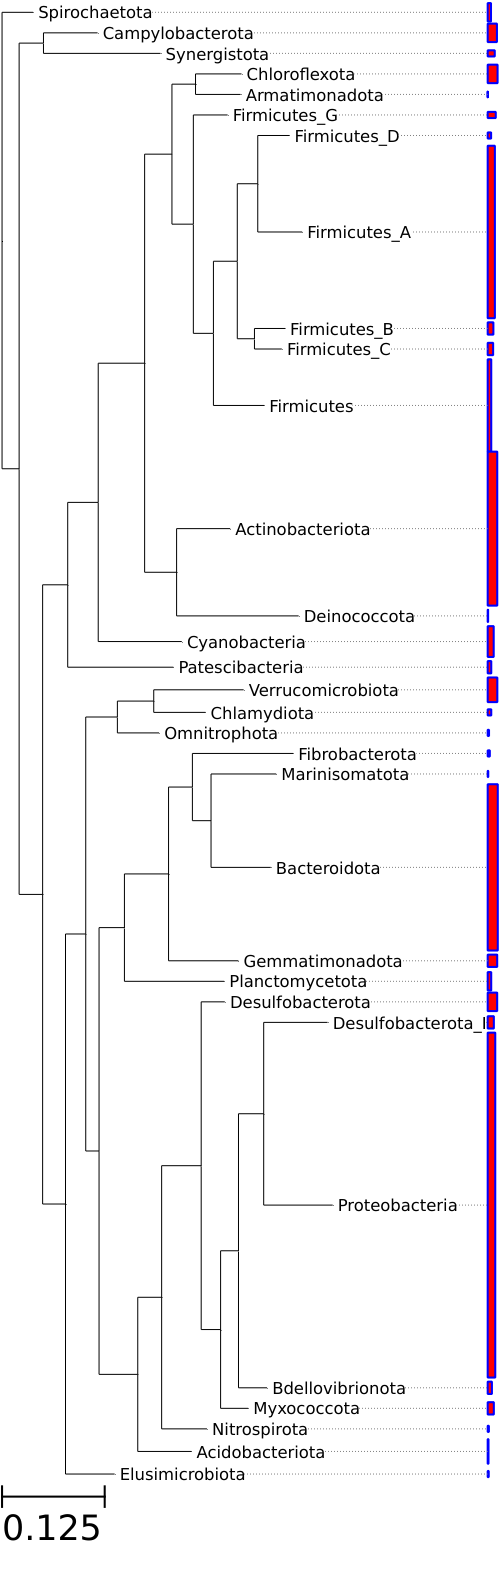

In [231]:
collapsed_phylum.render('%%inline', tree_style=ts, w=500)

In [232]:
rendered = collapsed_phylum.render('./../figures/phylum_tree_nolabels.svg', tree_style=ts) #, w=1600, dpi=400)

In [145]:
# pre-compute bars

bars_dict = {}
for i, (trait, cmap, log_vals) in enumerate(zip(traits, cmaps, log)):
    bars_dict[trait] = np.array([])
    
    for p in phyla_in_order:
        leaves = postorder_leaves[int(phylum_postorder.loc[p, 'start']):int(phylum_postorder.loc[p, 'stop'])]
        # print(len(leaves))
        a = pca_data.loc[leaves, trait]
        
        if log_vals:
            a = a.apply(np.log10)
        a = a.values
        p_bars = np.array([np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9]) for x in np.array_split(a, c[p])])
        # p_bars = np.array([x.mean() for x in np.array_split(a, c[p])])

        bars_dict[trait] = np.concatenate((bars_dict[trait], p_bars)) if len(bars_dict[trait]) > 0 else p_bars
        
        
bars_dict_mean = {}
for i, (trait, cmap, log_vals) in enumerate(zip(traits, cmaps, log)):
    bars_dict_mean[trait] = np.array([])
    
    for p in phyla_in_order:
        leaves = postorder_leaves[int(phylum_postorder.loc[p, 'start']):int(phylum_postorder.loc[p, 'stop'])]
        # print(len(leaves))
        a = pca_data.loc[leaves, trait]
        
        if log_vals:
            a = a.apply(np.log10)
        a = a.values
        # p_bars = np.array([np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9]) for x in np.array_split(a, c[p])])
        p_bars = np.array([x.mean() for x in np.array_split(a, c[p])])

        bars_dict_mean[trait] = np.concatenate((bars_dict_mean[trait], p_bars)) if len(bars_dict_mean[trait]) > 0 else p_bars

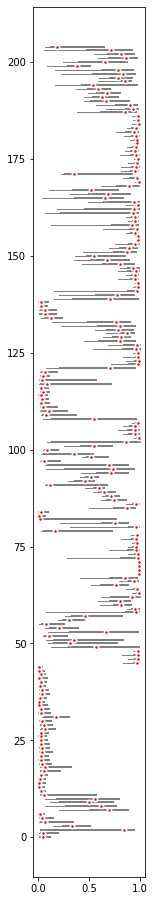

In [146]:
fig, ax = plt.subplots(figsize=(2, 16))
plt.scatter(x=bars_dict['aerobe'][:, 2], y=range(bars_dict['aerobe'].shape[0]), s=25, zorder=1, color='white')
plt.scatter(x=bars_dict['aerobe'][:, 2], y=range(bars_dict['aerobe'].shape[0]), s=2, zorder=2, color='red')

# thin lines
lines = [plt.plot((x1, x2), (i, i), color='gray', linewidth=1, zorder=0) for i,(x1, x2) in enumerate(bars_dict['aerobe'][:, :2])]
lines = [plt.plot((x1, x2), (i, i), color='gray', linewidth=1, zorder=0) for i,(x1, x2) in enumerate(bars_dict['aerobe'][:, 3:])]

# thick line
lines = [plt.plot((x1, x2), (i, i), color='gray', linewidth=2, zorder=0) for i,(x1, x2) in enumerate(bars_dict['aerobe'][:, [1,4]])]

In [187]:
xticks = [[0, 0.25, 0.5, 0.75, 1],
          [-0.3010299956639812, 0.0, 0.3010299956639812, 0.6020599913279624, 1.0],
          [0, 0.25, 0.5, 0.75, 1],
          [0, 0.25, 0.5, 0.75, 1],
          [25, 37.5, 50, 62.5, 75],
          [1e6,3e6,5e6,7e6,9e6]]

xticklabels = [['0','', '0.5', '', '1'],
          ['0.5', '1', '2', '4', '10'],
          ['0','', '50', '', '100'],
          ['0','', '50', '', '100'],
          ['25' , '', '50' , '', '75' ],
          ['1', '3', '5', '7', '9']]

xaxlabels = ['p (aerobe)',
             'Est. min.\ndoubling time (h$^{-1}$)',
            '% autotrophic',
            '% phototrophic',
            'GC content (%)',
            'Genome size (Mbp)']


aerobe
growth_rate
autotroph
phototroph
gc_percentage
genome_size


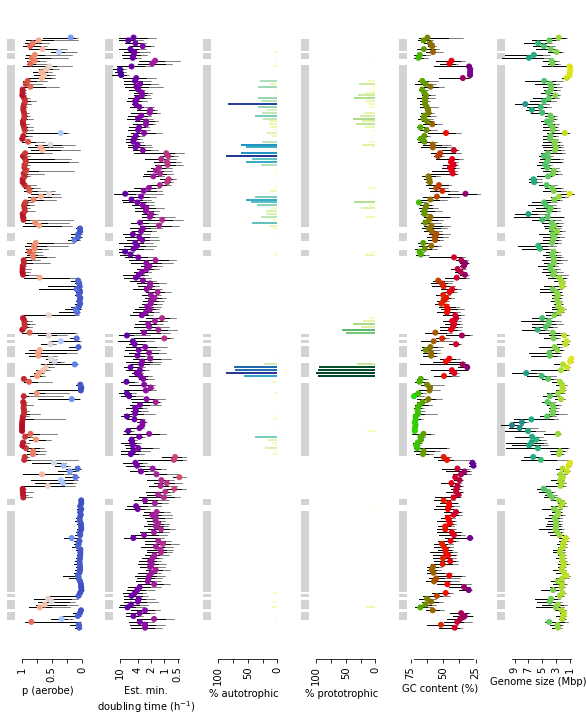

In [219]:
# define fig
fig = plt.figure(figsize=(12,12))

axes = []
for i, (trait, cmap_name, log_vals) in enumerate(zip(traits, cmaps, log)):
    
    print(trait)
    if i == 0:
        ax = fig.add_subplot(1, len(traits)+1, i+1)
        axes.append(ax)
    else:
        ax = fig.add_subplot(1, len(traits)+1, i+1, sharey=axes[0])
        axes.append(ax)
    
    # set up colormaps for elements, logging some values
    # yields a correctly normalized colormap
    
    cmap = mpl.colormaps[cmap_name]
    if log_vals:
        _min, _max = pca_data[trait].apply(np.log10).min(), pca_data[trait].apply(np.log10).max()
        norm = mpl.colors.Normalize(_min, _max)
    else:
        _min, _max = pca_data[trait].min(), pca_data[trait].max()
        norm = mpl.colors.Normalize(_min, _max)
    
    
    # set colors of bars using median
    bars = bars_dict[trait][:, 2]
    colors = [cmap(norm(b)) for b in bars]
    
    # help with data ranges
    _min, _max = np.min(bars), np.max(bars)
    _range = (_max - _min) / 2
    _mid = _min + _range
    
    # plot something different for autotrophy and phototrophy
    if i > 1 and i < 4:
            # plot lines
        bars = bars_dict_mean[trait]
        colors = [cmap(norm(b)) for b in bars]    
        
        ax.hlines(range(len(bars)), _min, bars, 
              linewidth=2,
              colors=colors, alpha=1, zorder=3)
    else:
    
        # plt.scatter(x=bars_dict[trait][:, 2], y=range(bars_dict[trait].shape[0]), s=25, zorder=1, color='white')
        plt.scatter(x=bars_dict[trait][:, 2], y=range(bars_dict[trait].shape[0]), s=25, zorder=2, color=colors)

        # thin lines
        lines = [plt.plot((x1, x2), (i, i), color='k', linewidth=0.5, zorder=1) for i,(x1, x2) in enumerate(bars_dict[trait][:, :2])]
        lines = [plt.plot((x1, x2), (i, i), color='k', linewidth=0.5, zorder=1) for i,(x1, x2) in enumerate(bars_dict[trait][:, 3:])]

        # thick line
        lines = [plt.plot((x1, x2), (i, i), color='k', linewidth=1, zorder=1) for i,(x1, x2) in enumerate(bars_dict[trait][:, [1,4]])]

    

    
#     x_axis_location = ax.spines['left'].get_position()[1]
    
    # add phylum-delineating element

    ax.set_xlim( _mid + _range*1.5, _mid - _range*1.25,)
    # ax.set_xlim(_mid - _range*1.5,  _mid + _range*1.5)

    # zebra
    alt = False
    j = 0
    for p in phyla_in_order:
        # ax.axhline(i-0.5, color='gray', zorder=0, linewidth=0.5)
        
        box_args = {
                    # 'xy':(0, j-0.5),
                    #   'width':1,
            'xy':(_mid + (_range * 1.25), j-0.5),
                      'width':_range*.25,
              'height':c[p],
              # 'transform':ax.transAxes,
              'linewidth':0,
              'edgecolor':'k',
              'facecolor':'lightgray' if alt else 'white',
              'label':'p', 'zorder':0}
        
        # if alt:
        original_box = patches.Rectangle(**box_args, # facecolor='lightgray',
                                 # hatch='\\'*10
                                        )
        ax.add_patch(original_box)
            
        # else:
        #     original_box = patches.Rectangle(**box_args,)# facecolor='white',)
        #     ax.add_patch(original_box)            
        
        alt = not alt
        j = j + c[p]
    
    
    ax.spines['bottom'].set_bounds(_min, _max)
    ax.set_xticks(xticks[i][::-1])
    ax.set_xticklabels(xticklabels[i][::-1])
    ax.tick_params(left=False, labelleft=False)
    ax.tick_params( rotation=90, axis='x')
    ax.set_xlabel(xaxlabels[i])
    # ax.set_ylim(n_bins+5, -5)
    
    sns.despine(ax=ax, left=True)
plt.savefig('./../figures/phylum_traits_boxstyle.svg', bbox_inches='tight')
plt.savefig('./../figures/phylum_traits_boxstyle.png', bbox_inches='tight', dpi=90)

In [245]:
(pca_data['autotroph'] == 1).sum() # / len(pca_data)

4697

In [238]:
np.set_printoptions(suppress=True)

##

aerobe


ValueError: could not broadcast input array from shape (1025,) into shape (205,)

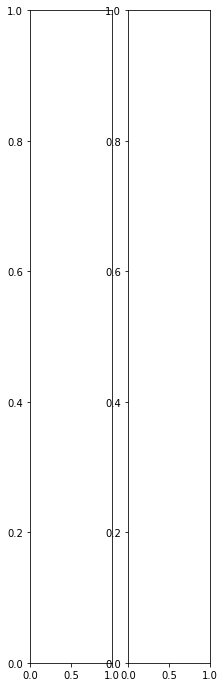

In [212]:
# define fig
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, len(traits)+1, 1)

for i, (trait, cmap_name, log_vals) in enumerate(zip(traits, cmaps, log)):
    
    print(trait)
    ax = fig.add_subplot(1, len(traits)+1, i+2)
    
    # set up data
    bars = bars_dict[trait]

    cmap = mpl.colormaps[cmap_name]
    if log_vals:
        _min, _max = pca_data[trait].apply(np.log10).min(), pca_data[trait].apply(np.log10).max()
        norm = mpl.colors.Normalize(_min, _max)
    else:
        _min, _max = pca_data[trait].min(), pca_data[trait].max()
        norm = mpl.colors.Normalize(_min, _max)
    
    colors = [cmap(norm(b)) for b in bars]
    
    
    # help with data ranges
    _min, _max = np.min(bars), np.max(bars)
    _range = (_max - _min) / 2
    _mid = _min + _range
    
    # plot lines
    ax.hlines(range(len(bars)), _min, bars, 
              linewidth=2,
              colors=colors, alpha=1, zorder=3)
    
    
    
    
    
    ax.set_xlim(_mid - _range*1.5, _mid + _range*1.25)
    
    # zebra
    alt = False
    i = 0
    
    x_axis_location = ax.spines['left'].get_position()[1]
    
    # add phylum-delineating element
    for p in phyla_in_order:
        # ax.axhline(i-0.5, color='gray', zorder=0, linewidth=0.5)
        
        box_args = {
                    'xy':(_mid - (_range*1.25), i-0.5),
              'width':_range*.25,
              'height':c[p],
              # 'transform':ax.transAxes,
              'linewidth':0,
              'edgecolor':'k',
              'facecolor':'none',
              'label':'p', 'zorder':1}
        
        if alt:
            original_box = patches.Rectangle(**box_args, #facecolor='lightgray',
                                     hatch='\\'*10
                                            )
            ax.add_patch(original_box)
            
        else:
            original_box = patches.Rectangle(**box_args,)# facecolor='white',)
            ax.add_patch(original_box)            
        
        alt = not alt
        i = i + c[p]
    
    ax.tick_params(left=False, labelleft=False)
    ax.set_ylim(n_bins, 0)
    sns.despine()
# plt.savefig('./../figures/phylum_traits_barstyle.svg', bbox_inches='tight')

In [53]:
bars

array([2835438.79562044, 2867774.46323529, 3348601.99264706,
       2057269.84393064, 2134713.60693642, 1899539.43604651,
       2312758.86153846, 3475895.83886256, 3062403.41706161,
       3989202.75238095, 4110545.19277108, 2512126.41333333,
       2112295.36734694, 3579998.27402135, 2520759.66548043,
       2268858.68683274, 2796810.51245552, 2168559.50533808,
       1511680.7366548 , 2067904.77935943, 2358528.9252669 ,
       2143195.44128114, 1911707.66548043, 2057851.33807829,
       2216697.7544484 , 2143620.79715302, 2491478.9252669 ,
       2417790.87544484, 2057152.07117438, 2085635.03914591,
       1869349.91814947, 1753156.08896797, 2632436.95729537,
       2975471.30357143, 3378883.56428571, 3196046.66071429,
       3158601.33928571, 3152217.38571429, 3334688.75714286,
       2821059.46428571, 2756377.81785714, 3415725.84126984,
       2449697.07142857, 2161455.15104167, 2722093.85416667,
       3639148.07434944, 3877626.04832714, 4222887.58364312,
       4865511.62825279,

In [480]:
leaf_sets = []
for p in phyla_in_order:
    leaves = postorder_leaves[int(phylum_postorder.loc[p, 'start']):int(phylum_postorder.loc[p, 'stop'])]
    for leaf_set in np.array_split(leaves, c[p]):
        leaf_sets.append(set(leaf_set))

In [27]:
def collapse_tree_n(tree): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapse_to_ncount(n), format=3),format=3) 
    t.name = tree.name
    return t

def collapse_to_ncount(node):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    value = False
    leaf_value = False
    # if node.is_leaf():
    #     return True
    # else:
    leaves = set([l.name for l in node.get_leaves()])
    if any([len(l - leaves)])

def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
    if node.is_leaf():
        
        new_name = top_phyla_clades.loc[node.name].split(':')[-1].split(';')[0].lstrip()
        
        faces.add_face_to_node(TextFace(f" {new_name}", fsize=6), node, column=0)
        
        num_leaves = len(gtdb_full.search_nodes(name=node.name)[0].get_leaves())
        faces.add_face_to_node(TextFace(f"      {num_leaves}", fsize=6), node, column=2, position='aligned')
    
        face_color='k'
#         if num_leaves >= 1900:
            
#             face_color='red'
            
        # face_color = node_size_cmap(len(node.get_leaves()) / 2000)
        
        R1 = RectFace(width=num_leaves / 100,
                      height=3, 
              fgcolor=face_color,
              bgcolor=face_color)
        faces.add_face_to_node(R1, node, 3, position='aligned')

        
        internal_ns['fgcolor'] = face_color
        internal_ns['size'] = 5

    node.img_style = internal_ns

ts = TreeStyle()
# ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=400
ts.show_leaf_name = False
ts.draw_guiding_lines = False

In [28]:
collapsed_phylum = collapse_tree_phylum(gtdb_pruned)

In [29]:
collapsed_phylum.describe()

Number of leaf nodes:	4507
Total number of nodes:	9013
Rooted:	Yes
Most distant node:	RS_GCF_000008205_1
Max. distance:	2.646470


In [30]:
collapsed_phylum.prune(list(top_phyla_clades.index)) #[c for c in collapsed_phylum.get_leaves() if names_map.loc[c.name].split(':')[-1].split(';')[0].lstrip('p_') in md_top_phyla['Phylum'].unique()], 
                       # preserve_branch_length=True)

In [31]:
collapsed_phylum.describe()

Number of leaf nodes:	31
Total number of nodes:	61
Rooted:	Yes
Most distant node:	c006481
Max. distance:	0.402630


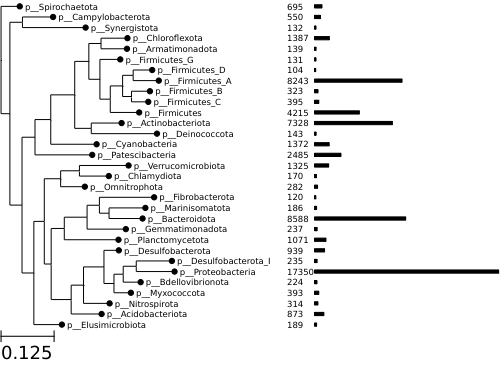

In [32]:
collapsed_phylum.render('%%inline', tree_style=ts, w=500)

In [478]:
gradient = np.linspace(0, 1, len(y_values)).reshape(-1, 1)
ax.imshow(gradient, aspect='auto', cmap='Blues', alpha=0.2, extent=[0, 10, 0, 20])


NameError: name 'y_values' is not defined

In [396]:
ax.spines['left'].get_position()

['c000001',
 'c000001',
 'c000001',
 'c000178',
 'c000178',
 'c000178',
 'c000123',
 'c000596',
 'c000596',
 'c000596']

In [341]:
p_bars.shape

(136,)

### Individual sub-plots for wavelet data

In [387]:
SAVE_DATA = True

#### aerobe plot

In [382]:
# get the ten largest wavelets for this trait
n = 10
n_largest = varexp_ind_df.loc[:, 'aerobe'].sort_values(ascending=False).head(n)

In [383]:
# get the bounds of the clades for each wavelet
# xs: location of wavelet from root
# ys: upper and lower limit of children's leaf locaiton, in postorder
# provide bounds for a box to superimpose on postordered leaves, delineating clades
treeplot_xs, treeplot_ys = [], []
count = n
for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
    if not _node.is_leaf() and _node.name in n_largest.index:
        for node in _node.get_children():
            ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
            treeplot_ys.append([ymin, ymax])
            treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
        count -= 1

In [384]:
# reverse for the purposes of plotting
# plot largest clades first ... ? 
treeplot_xs = treeplot_xs[::-1]
treeplot_ys = treeplot_ys[::-1]

In [385]:
# get set of distances from root to largest clades
hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))

In [386]:
# get maximum distance, for setting axis bounds
xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])

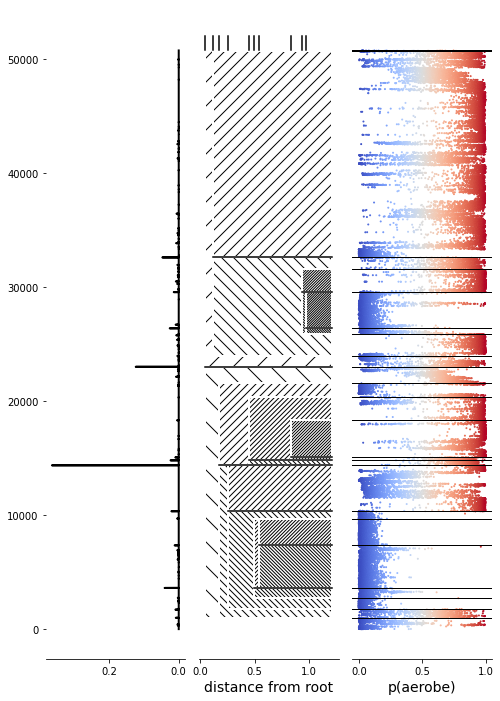

In [510]:
fig = plt.figure(figsize=(8, 12))

### ------------------------------------------------
# Plot 1: wavelets
### ------------------------------------------------

# Define a GridSpec with 3 rows and 3 columns
gs = GridSpec(1, 3, figure=fig) 

ax1 = fig.add_subplot(gs[0, 0])

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, 'aerobe'].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

xlims = ax1.get_xlim()
ax1.set_xlim(xlims[1], xlims[0])

### ------------------------------------------------
# Plot 2: tree breakdown
### ------------------------------------------------

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

# include rugplot of significant wavelets on top of 
rugplot_x = [treeplot_xs[i][0] for i in range(0, len(treeplot_xs), 2)]
for _x in rugplot_x:
    plt.plot((_x, _x), (5.0750e4, 5.2e4), color='k')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    # xmax = treeplot_xs[i][0] * 1.25 # len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='k')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='/'*(hash_values.index(xmin)+1), 
                          linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    # xmax = treeplot_xs[i][0] * 1.25  #len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='\\'*(hash_values.index(xmin)+1), linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)

# ax.set_axis_off()
# ax.set_xlim(1, 11)
ax2.yaxis.set_visible(False)
ax2.set_xlabel('distance from root', fontsize=14)
sns.despine(left=True)

# ### ------------------------------------------------
# # Plot 3: traits
# ### ------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

x = pca_data.reindex(postorder_leaves)['aerobe'].values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['coolwarm']
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
            s=1)

for item in treeplot_ys:
    ax3.axhline(item[0], color='k', linewidth=1, alpha=1)
    ax3.axhline(item[1], color='k', linewidth=1, alpha=1)
    
    # ax.axhline(item[0], color='white', alpha=0.75)
    # ax.axhline(item[1], color='white', alpha=0.75)
    
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

ax3.set_xlabel('p(aerobe)', fontsize=14)

fig.subplots_adjust(wspace=0.1, hspace=0)

# # # ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if SAVE_DATA:
    plt.savefig('./../figures/haar_method/wt_aerobe.svg', bbox_inches='tight', transparent=True)
    plt.savefig('./../figures/haar_method/wt_aerobe.png',
                dpi=400, 
                bbox_inches='tight', transparent=True)
else:
    plt.savefig('./../figures/haar_method/wt_aerobe_nodata.svg', bbox_inches='tight', transparent=True)
    plt.savefig('./../figures/haar_method/wt_aerobe_nodata.png',
                dpi=400, 
                bbox_inches='tight', transparent=True)
plt.show()

#### growth rate plot

In [447]:
len(pca_data)

50745

In [391]:
# get the ten largest wavelets for this trait
n = 10
n_largest = varexp_ind_df.loc[:, 'growth_rate'].sort_values(ascending=False).head(n)

In [392]:
# get the bounds of the clades for each wavelet
# xs: location of wavelet from root
# ys: upper and lower limit of children's leaf locaiton, in postorder
# provide bounds for a box to superimpose on postordered leaves, delineating clades
treeplot_xs, treeplot_ys = [], []
count = n
for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
    if not _node.is_leaf() and _node.name in n_largest.index:
        for node in _node.get_children():
            ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
            treeplot_ys.append([ymin, ymax])
            treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
        count -= 1

In [393]:
# reverse for the purposes of plotting
# plot largest clades first ... ? 
treeplot_xs = treeplot_xs[::-1]
treeplot_ys = treeplot_ys[::-1]

In [394]:
# get set of distances from root to largest clades
hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))

In [395]:
# get maximum distance, for setting axis bounds
xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])

In [399]:
SAVE_DATA = True

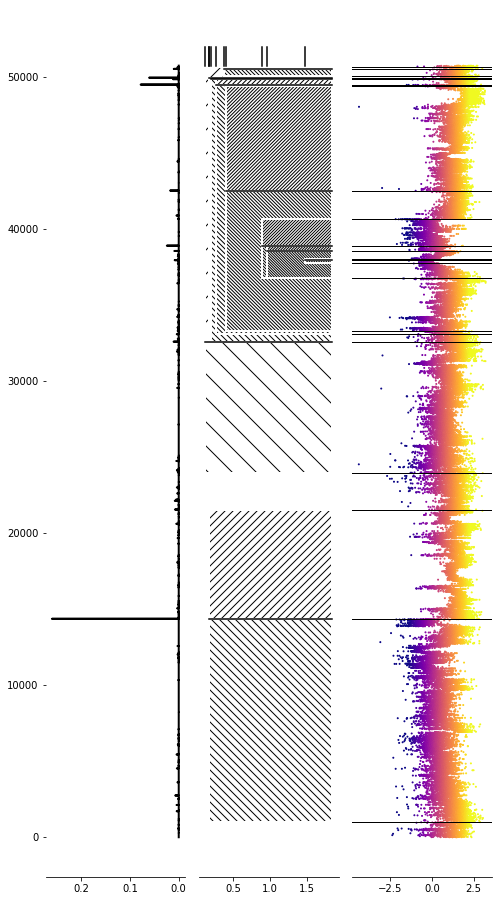

In [400]:
fig = plt.figure(figsize=(8, 16))

### ------------------------------------------------
# Plot 1: wavelets
### ------------------------------------------------

# Define a GridSpec with 3 rows and 3 columns
gs = GridSpec(1, 3, figure=fig) #, height_ratios=[1,5])

ax1 = fig.add_subplot(gs[0, 0])

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, 'growth_rate'].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

xlims = ax1.get_xlim()
ax1.set_xlim(xlims[1], xlims[0])

## --------------------------------------------
# Plot of distribution of phylogenetic distances for different taxonomic levels
## --------------------------------------------

# ax4 = fig.add_subplot(gs[0, 1])

# sns.kdeplot(ax = ax4,
#     data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')], 
#             x='dist', hue='level', 
#             common_norm=False, fill=True,
#            linewidth=0, alpha=0.75, palette='Grays', 
#             hue_order=['p', 'c', 'o', 'f', 'g'][::-1])


# ax4.set_xlim(-0.25, xmax)
# ax4.set_xlabel('')

### ------------------------------------------------
# Plot 2: tree breakdown
### ------------------------------------------------

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1) #, sharex=ax4)

# include rugplot of significant wavelets on top of 
rugplot_x = [treeplot_xs[i][0] for i in range(0, len(treeplot_xs), 2)]
for _x in rugplot_x:
    plt.plot((_x, _x), (5.0750e4, 5.2e4), color='k')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    # xmax = treeplot_xs[i][0] * 1.25 # len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='k')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='/'*(hash_values.index(xmin)+1), 
                          linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    # xmax = treeplot_xs[i][0] * 1.25  #len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='\\'*(hash_values.index(xmin)+1), linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)

# ax.set_axis_off()
# ax.set_xlim(1, 11)
ax2.yaxis.set_visible(False)
sns.despine(left=True)

# ### ------------------------------------------------
# # Plot 3: traits
# ### ------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

norm = mpl.colors.Normalize(vmin=-2,
                            vmax=pca_data['growth_rate'].apply(np.log).max())

x = pca_data.reindex(postorder_leaves)['growth_rate'].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['plasma']
colors = [to_hex(cmap(norm(np.log2(pca_data.loc[i, 'growth_rate'])))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)

for item in treeplot_ys:
    ax3.axhline(item[0], color='k', linewidth=1, alpha=1)
    ax3.axhline(item[1], color='k', linewidth=1, alpha=1)
    
    # ax.axhline(item[0], color='white', alpha=0.75)
    # ax.axhline(item[1], color='white', alpha=0.75)
    
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

fig.subplots_adjust(wspace=0.1, hspace=0)


# # # ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if SAVE_DATA:
    plt.savefig('./../figures/haar_method/wt_growth_rate.svg', 
                transparent=True, bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_growth_rate.png', 
                transparent=True, bbox_inches='tight', dpi=400)
else:
    plt.savefig('./../figures/haar_method/wt_growth_rate_nodata.svg', 
                transparent=True, bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_growth_rate_nodata.png', 
                transparent=True, bbox_inches='tight', dpi=400)

plt.show()

In [539]:
norm = mpl.colors.Normalize(vmin=-2,
                            vmax=np.log2(pca_data['growth_rate']) )
# norm(0)

x = pca_data.reindex(postorder_leaves)['growth_rate'].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['plasma']
colors = [to_hex(cmap(norm(np.log2(pca_data.loc[i, 'growth_rate'])))) for i in postorder_leaves]

plt.scatter(x, y, c=colors,
            s=1)

#### photosynthesis plot

In [401]:
# get the ten largest wavelets for this trait
n = 10
n_largest = varexp_ind_df.loc[:, 'phototroph'].sort_values(ascending=False).head(n)

In [402]:
# get the bounds of the clades for each wavelet
# xs: location of wavelet from root
# ys: upper and lower limit of children's leaf locaiton, in postorder
# provide bounds for a box to superimpose on postordered leaves, delineating clades
treeplot_xs, treeplot_ys = [], []
count = n
for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
    if not _node.is_leaf() and _node.name in n_largest.index:
        for node in _node.get_children():
            ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
            treeplot_ys.append([ymin, ymax])
            treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
        count -= 1

In [403]:
# reverse for the purposes of plotting
# plot largest clades first ... ? 
treeplot_xs = treeplot_xs[::-1]
treeplot_ys = treeplot_ys[::-1]

In [404]:
# get set of distances from root to largest clades
hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))

In [405]:
# get maximum distance, for setting axis bounds
xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])

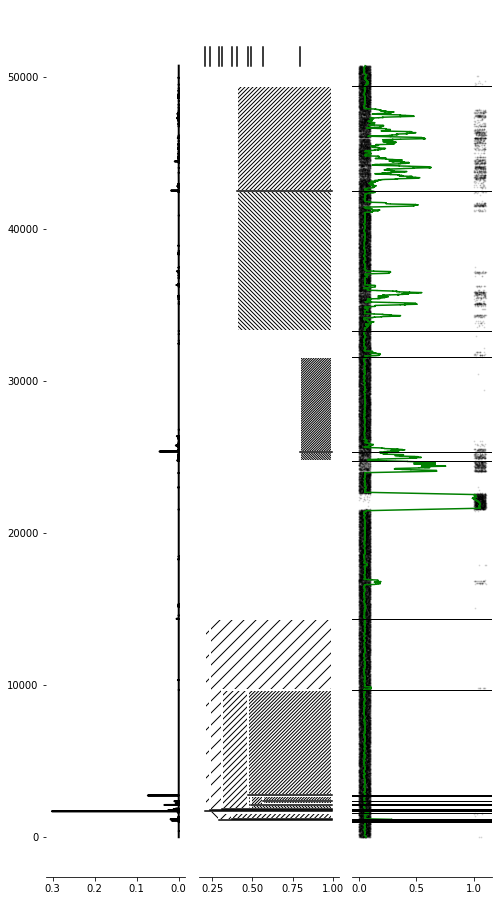

In [406]:
fig = plt.figure(figsize=(8, 16))

### ------------------------------------------------
# Plot 1: wavelets
### ------------------------------------------------

# Define a GridSpec with 3 rows and 3 columns
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, 'phototroph'].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

xlims = ax1.get_xlim()
ax1.set_xlim(xlims[1], xlims[0])

## --------------------------------------------
# Plot of distribution of phylogenetic distances for different taxonomic levels
## --------------------------------------------

# ax4 = fig.add_subplot(gs[0, 1])

# sns.kdeplot(ax = ax4,
#     data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')], 
#             x='dist', hue='level', 
#             common_norm=False, fill=True,
#            linewidth=0, alpha=0.75, palette='Grays', 
#             hue_order=['p', 'c', 'o', 'f', 'g'][::-1])


# ax4.set_xlim(-0.25, xmax)
# ax4.set_xlabel('')

### ------------------------------------------------
# Plot 2: tree breakdown
### ------------------------------------------------

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

# include rugplot of significant wavelets on top of 
rugplot_x = [treeplot_xs[i][0] for i in range(0, len(treeplot_xs), 2)]
for _x in rugplot_x:
    plt.plot((_x, _x), (5.0750e4, 5.2e4), color='k')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    # xmax = treeplot_xs[i][0] * 1.25 # len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='k')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='/'*(hash_values.index(xmin)+1), 
                          linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    # xmax = treeplot_xs[i][0] * 1.25  #len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='\\'*(hash_values.index(xmin)+1), linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)

# ax.set_axis_off()
# ax.set_xlim(1, 11)
ax2.yaxis.set_visible(False)
sns.despine(left=True)

# ### ------------------------------------------------
# # Plot 3: traits
# ### ------------------------------------------------

ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

norm = mpl.colors.Normalize(vmin=0,
                            vmax=1)
# runs = np.array(consecutive_counts(pca_data.reindex(postorder_leaves)['phototroph'].values))
x = pca_data.reindex(postorder_leaves)['phototroph'].values + (np.random.random(len(postorder_leaves)) / 10)
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['plasma']
# colors = [to_hex(cmap(norm(np.log2(pca_data.loc[i, 'phototroph'])))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c='k',
                s=1, alpha=0.1)

# plot sliding average line
window_size = 151
line_x = sliding_window_average_same_length(x, #pca_data.reindex(postorder_leaves)['phototroph'].values, 
                                            window_size) #np.convolve(x, np.ones(window_size) / window_size, mode='valid')

plt.plot(line_x, y, c='green')

for item in treeplot_ys:
    ax3.axhline(item[0], color='k', linewidth=1, alpha=1)
    ax3.axhline(item[1], color='k', linewidth=1, alpha=1)
    
    # ax.axhline(item[0], color='white', alpha=0.75)
    # ax.axhline(item[1], color='white', alpha=0.75)
    
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

fig.subplots_adjust(wspace=0.1, hspace=0)


# # # ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax1.set_ylim(-100, 2e4)
if SAVE_DATA:
    plt.savefig('./../figures/haar_method/wt_phototroph.svg', bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_phototroph.png', bbox_inches='tight', dpi=400)

else:
    plt.savefig('./../figures/haar_method/wt_phototroph_nodata.svg', 
                bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_phototroph_nodata.png', 
                bbox_inches='tight', dpi=400)
plt.show()

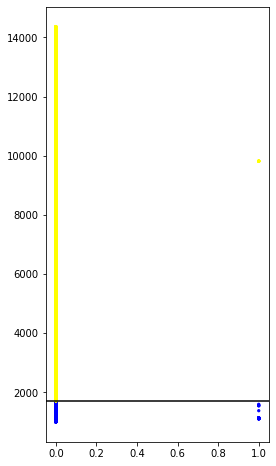

In [63]:
check_children(gtdb_pruned.search_nodes(name='c000193')[0], 
               np_pca_data['phototroph'], 
               pd.Series(index=postorder_leaves,
                         data=range(len(postorder_leaves))),
              node_xlocs)

#### carbon plot

In [97]:
# get the ten largest wavelets for this trait
n = 10
n_largest = varexp_ind_df.loc[:, 'Calvin Cycle'].sort_values(ascending=False).head(n)

In [98]:
# get the bounds of the clades for each wavelet
# xs: location of wavelet from root
# ys: upper and lower limit of children's leaf locaiton, in postorder
# provide bounds for a box to superimpose on postordered leaves, delineating clades
treeplot_xs, treeplot_ys = [], []
count = n
for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
    if not _node.is_leaf() and _node.name in n_largest.index:
        for node in _node.get_children():
            ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
            treeplot_ys.append([ymin, ymax])
            treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
        count -= 1

In [99]:
# reverse for the purposes of plotting
# plot largest clades first ... ? 
treeplot_xs = treeplot_xs[::-1]
treeplot_ys = treeplot_ys[::-1]

In [100]:
# get set of distances from root to largest clades
hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))

In [101]:
# get maximum distance, for setting axis bounds
xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])

50745
50745


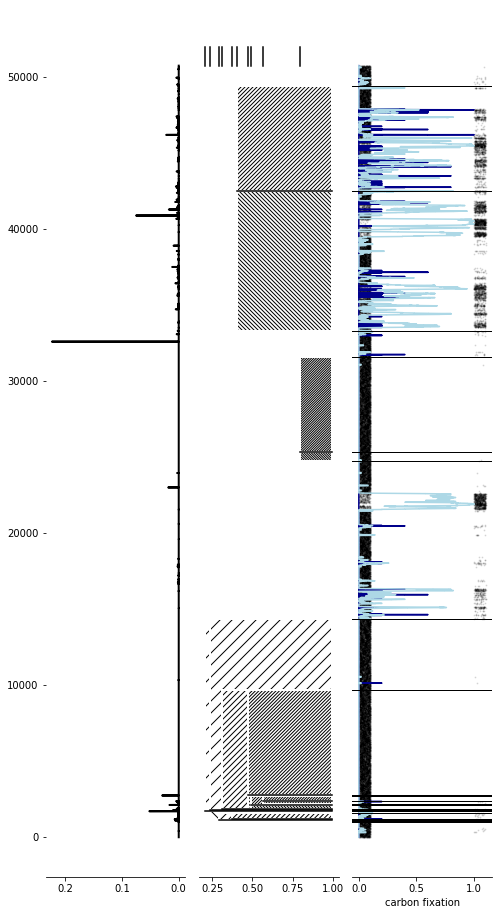

In [407]:
fig = plt.figure(figsize=(8, 16))

### ------------------------------------------------
# Plot 1: wavelets
### ------------------------------------------------

# Define a GridSpec with 3 rows and 3 columns
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, 'Calvin Cycle'].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

xlims = ax1.get_xlim()
ax1.set_xlim(xlims[1], xlims[0])

## --------------------------------------------
# Plot of distribution of phylogenetic distances for different taxonomic levels
## --------------------------------------------

# ax4 = fig.add_subplot(gs[0, 1])

# sns.kdeplot(ax = ax4,
#     data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')], 
#             x='dist', hue='level', 
#             common_norm=False, fill=True,
#            linewidth=0, alpha=0.75, palette='Grays', 
#             hue_order=['p', 'c', 'o', 'f', 'g'][::-1])


# ax4.set_xlim(-0.25, xmax)
# ax4.set_xlabel('')

### ------------------------------------------------
# Plot 2: tree breakdown
### ------------------------------------------------

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

# include rugplot of significant wavelets on top of 
rugplot_x = [treeplot_xs[i][0] for i in range(0, len(treeplot_xs), 2)]
for _x in rugplot_x:
    plt.plot((_x, _x), (5.0750e4, 5.2e4), color='k')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    # xmax = treeplot_xs[i][0] * 1.25 # len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='k')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='/'*(hash_values.index(xmin)+1), 
                          linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    # xmax = treeplot_xs[i][0] * 1.25  #len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='\\'*(hash_values.index(xmin)+1), linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)

# ax.set_axis_off()
# ax.set_xlim(1, 11)
ax2.yaxis.set_visible(False)
sns.despine(left = True)

# ### ------------------------------------------------
# # Plot 3: traits
# ### ------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

# aggregation of carbon fixation trait
carbon_sum = (pca_data[['3HP bicycle', 'Calvin Cycle']].sum(1) > 0).astype(int)
x = carbon_sum.reindex(postorder_leaves).values + (np.random.random(len(postorder_leaves)) / 10)

y = list(range(len(postorder_leaves)))

if SAVE_DATA:
    plt.scatter(x, y, c='k',
                s=1, alpha=0.1)

# plot sliding average line
for cycle, _c, window_size in zip(['3HP bicycle', 'Calvin Cycle'],
                     ['darkblue', 'lightblue'],
                     [5, 50]):
    x = pca_data.reindex(postorder_leaves)[cycle].values
    line_x = sliding_window_average_same_length(x,
                                                window_size)
    
    if len(line_x) < len(y):
        line_x = np.append(line_x, [0])
    print(len(line_x))
    
    plt.plot(line_x, y, c=_c)

ax3.set_xlabel('carbon fixation')

for item in treeplot_ys:
    ax3.axhline(item[0], color='k', linewidth=1, alpha=1)
    ax3.axhline(item[1], color='k', linewidth=1, alpha=1)
    
    # ax.axhline(item[0], color='white', alpha=0.75)
    # ax.axhline(item[1], color='white', alpha=0.75)
    
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

fig.subplots_adjust(wspace=0.1, hspace=0)


# # # ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax1.set_ylim(-100, 2e4)

if SAVE_DATA:
    plt.savefig('./../figures/haar_method/wt_calvin.svg', bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_calvin.png', bbox_inches='tight', dpi=400)
else:
    plt.savefig('./../figures/haar_method/wt_calvin_nodata.svg', bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_calvin_nodata.png', bbox_inches='tight', dpi=400)
    
plt.show()

#### GC content plot

In [408]:
# get the ten largest wavelets for this trait
n = 10
n_largest = varexp_ind_df.loc[:, 'gc_percentage'].sort_values(ascending=False).head(n)

In [409]:
# get the bounds of the clades for each wavelet
# xs: location of wavelet from root
# ys: upper and lower limit of children's leaf locaiton, in postorder
# provide bounds for a box to superimpose on postordered leaves, delineating clades
treeplot_xs, treeplot_ys = [], []
count = n
for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
    if not _node.is_leaf() and _node.name in n_largest.index:
        for node in _node.get_children():
            ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
            treeplot_ys.append([ymin, ymax])
            treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
        count -= 1

In [410]:
# reverse for the purposes of plotting
# plot largest clades first ... ? 
treeplot_xs = treeplot_xs[::-1]
treeplot_ys = treeplot_ys[::-1]

In [411]:
# get set of distances from root to largest clades
hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))

In [412]:
# get maximum distance, for setting axis bounds
xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])

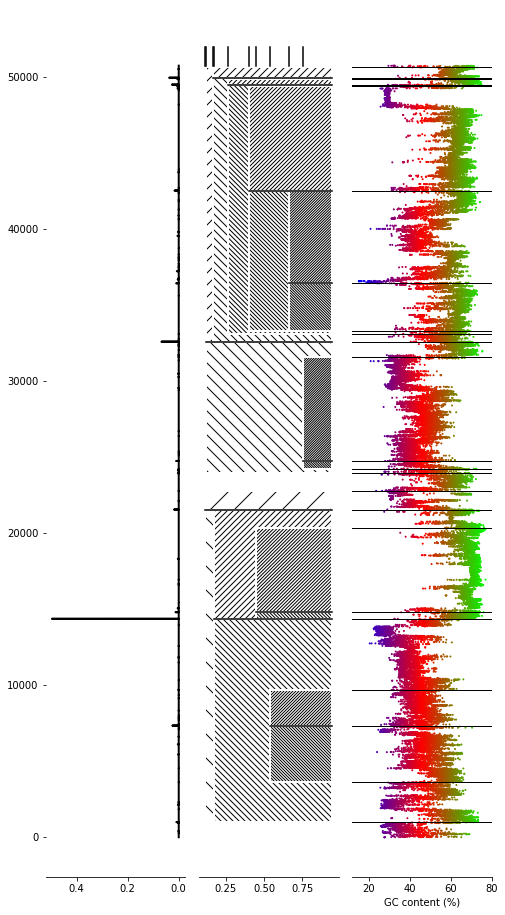

In [414]:
fig = plt.figure(figsize=(8, 16))

### ------------------------------------------------
# Plot 1: wavelets
### ------------------------------------------------

# Define a GridSpec with 3 rows and 3 columns
gs = GridSpec(1, 3, figure=fig) #, height_ratios=[1,5])

ax1 = fig.add_subplot(gs[0, 0])

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, 'gc_percentage'].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

xlims = ax1.get_xlim()
ax1.set_xlim(xlims[1], xlims[0])

## --------------------------------------------
# Plot of distribution of phylogenetic distances for different taxonomic levels
## --------------------------------------------

# ax4 = fig.add_subplot(gs[0, 1])

# sns.kdeplot(ax = ax4,
#     data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')], 
#             x='dist', hue='level', 
#             common_norm=False, fill=True,
#            linewidth=0, alpha=0.75, palette='Grays', 
#             hue_order=['p', 'c', 'o', 'f', 'g'][::-1])


# ax4.set_xlim(-0.25, xmax)
# ax4.set_xlabel('')

### ------------------------------------------------
# Plot 2: tree breakdown
### ------------------------------------------------

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1) #, sharex=ax4)

# include rugplot of significant wavelets on top of 
rugplot_x = [treeplot_xs[i][0] for i in range(0, len(treeplot_xs), 2)]
for _x in rugplot_x:
    plt.plot((_x, _x), (5.0750e4, 5.2e4), color='k')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    # xmax = treeplot_xs[i][0] * 1.25 # len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='k')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='/'*(hash_values.index(xmin)+1), 
                          linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    # xmax = treeplot_xs[i][0] * 1.25  #len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='\\'*(hash_values.index(xmin)+1), linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)

# ax.set_axis_off()
# ax.set_xlim(1, 11)
ax2.yaxis.set_visible(False)
sns.despine(left=True)

# ### ------------------------------------------------
# # Plot 3: traits
# ### ------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

norm = mpl.colors.Normalize(vmin=pca_data['gc_percentage'].min(),
                            vmax=pca_data['gc_percentage'].max())

x = pca_data.reindex(postorder_leaves)['gc_percentage'].values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['brg']
colors = [to_hex(cmap(norm(pca_data.loc[i, 'gc_percentage']))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)

for item in treeplot_ys:
    ax3.axhline(item[0], color='k', linewidth=1, alpha=1)
    ax3.axhline(item[1], color='k', linewidth=1, alpha=1)
    
    # ax.axhline(item[0], color='white', alpha=0.75)
    # ax.axhline(item[1], color='white', alpha=0.75)

ax3.set_xlabel('GC content (%)')

plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

fig.subplots_adjust(wspace=0.1, hspace=0)


# # # ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if SAVE_DATA:
    plt.savefig('./../figures/haar_method/wt_gc_percentage.svg', 
                transparent=True, bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_gc_percentage.png', 
                transparent=True, bbox_inches='tight', dpi=400)
else:
    plt.savefig('./../figures/haar_method/wt_gc_percentage_nodata.svg', 
                transparent=True, bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_gc_percentage_nodata.png', 
                transparent=True, bbox_inches='tight', dpi=400)

plt.show()

#### Genome size plot

In [416]:
# get the ten largest wavelets for this trait
n = 10
n_largest = varexp_ind_df.loc[:, 'genome_size'].sort_values(ascending=False).head(n)

In [417]:
# get the bounds of the clades for each wavelet
# xs: location of wavelet from root
# ys: upper and lower limit of children's leaf locaiton, in postorder
# provide bounds for a box to superimpose on postordered leaves, delineating clades
treeplot_xs, treeplot_ys = [], []
count = n
for i, _node in enumerate(gtdb_pruned.traverse(strategy='postorder')):
    if not _node.is_leaf() and _node.name in n_largest.index:
        for node in _node.get_children():
            ymin, ymax = po_leaf_series.loc[[l.name for l in node.get_leaves()]].aggregate(['min', 'max'])
            treeplot_ys.append([ymin, ymax])
            treeplot_xs.append([gtdb_pruned.get_distance(_node), len(n_largest)])
        count -= 1

In [418]:
# reverse for the purposes of plotting
# plot largest clades first ... ? 
treeplot_xs = treeplot_xs[::-1]
treeplot_ys = treeplot_ys[::-1]

In [419]:
# get set of distances from root to largest clades
hash_values = sorted(list(set([treeplot_xs[i][0] for i in range(len(treeplot_xs))])))

In [420]:
# get maximum distance, for setting axis bounds
xmax = np.max([treeplot_xs[i][0] * 1.25 for i in range(len(treeplot_xs))])

In [421]:
SAVE_DATA = True

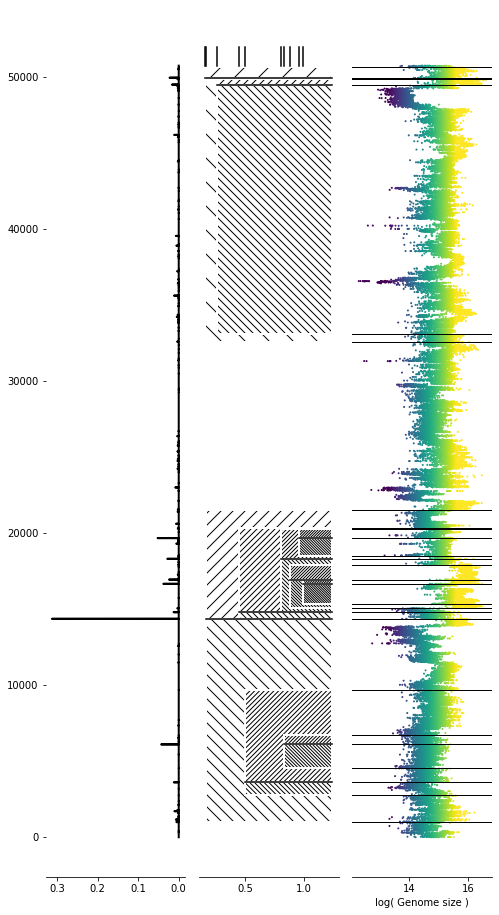

In [435]:
fig = plt.figure(figsize=(8, 16))

### ------------------------------------------------
# Plot 1: wavelets
### ------------------------------------------------

# Define a GridSpec with 3 rows and 3 columns
gs = GridSpec(1, 3, figure=fig) #, height_ratios=[1,5])

ax1 = fig.add_subplot(gs[0, 0])

plt.plot(varexp_ind_df.loc[node_xlocs.sort_values().index, 'genome_size'].values, 
         node_xlocs.sort_values().values, color='k', linewidth=2)

xlims = ax1.get_xlim()
ax1.set_xlim(xlims[1], xlims[0])

## --------------------------------------------
# Plot of distribution of phylogenetic distances for different taxonomic levels
## --------------------------------------------

# ax4 = fig.add_subplot(gs[0, 1])

# sns.kdeplot(ax = ax4,
#     data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')], 
#             x='dist', hue='level', 
#             common_norm=False, fill=True,
#            linewidth=0, alpha=0.75, palette='Grays', 
#             hue_order=['p', 'c', 'o', 'f', 'g'][::-1])


# ax4.set_xlim(-0.25, xmax)
# ax4.set_xlabel('')

### ------------------------------------------------
# Plot 2: tree breakdown
### ------------------------------------------------

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1) #, sharex=ax4)

# include rugplot of significant wavelets on top of 
rugplot_x = [treeplot_xs[i][0] for i in range(0, len(treeplot_xs), 2)]
for _x in rugplot_x:
    plt.plot((_x, _x), (5.0750e4, 5.2e4), color='k')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    # xmax = treeplot_xs[i][0] * 1.25 # len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='k')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='/'*(hash_values.index(xmin)+1), 
                          linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    # xmax = treeplot_xs[i][0] * 1.25  #len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='k', facecolor='white', hatch='\\'*(hash_values.index(xmin)+1), linewidth=2)
    ax2.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax2.add_patch(polygon)

# ax.set_axis_off()
# ax.set_xlim(1, 11)
ax2.yaxis.set_visible(False)
sns.despine(left=True)

# ### ------------------------------------------------
# # Plot 3: traits
# ### ------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

norm = mpl.colors.Normalize(vmin=pca_data['genome_size'].apply(np.log).min()+1,
                            vmax=pca_data['genome_size'].apply(np.log).max()-1)

x = pca_data.reindex(postorder_leaves)['genome_size'].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['viridis']
colors = [to_hex(cmap(norm(np.log(pca_data.loc[i, 'genome_size'])))) for i in postorder_leaves]

if SAVE_DATA:
    plt.scatter(x, y, c=colors,
                s=1)

for item in treeplot_ys:
    ax3.axhline(item[0], color='k', linewidth=1, alpha=1)
    ax3.axhline(item[1], color='k', linewidth=1, alpha=1)
    
    # ax.axhline(item[0], color='white', alpha=0.75)
    # ax.axhline(item[1], color='white', alpha=0.75)
    
ax3.set_xlabel('log( Genome size )')
plt.tick_params(left=False, labelleft=False)
sns.despine(left=True)

fig.subplots_adjust(wspace=0.1, hspace=0)


# # # ax.set_yscale('log')
# # lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if SAVE_DATA:
    plt.savefig('./../figures/haar_method/wt_genome_size.svg', 
                transparent=True, bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_genome_size.png', 
                transparent=True, bbox_inches='tight', dpi=400)
else:
    plt.savefig('./../figures/haar_method/wt_genome_size_nodata.svg', 
                transparent=True, bbox_inches='tight')
    plt.savefig('./../figures/haar_method/wt_genome_size_nodata.png', 
                transparent=True, bbox_inches='tight', dpi=400)

plt.show()

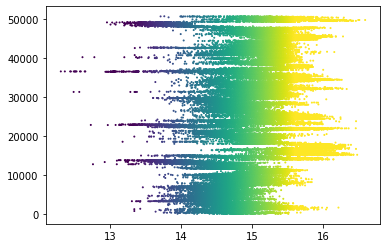

In [433]:
norm = mpl.colors.Normalize(vmin=np.log(pca_data['genome_size']).min()+1,
                            vmax=np.log(pca_data['genome_size']).max()-1)
# norm(0)

x = pca_data.reindex(postorder_leaves)['genome_size'].apply(np.log).values
y = list(range(len(postorder_leaves)))
cmap = matplotlib.colormaps['viridis']
colors = [to_hex(cmap(norm(np.log(pca_data.loc[i, 'genome_size'])))) for i in postorder_leaves]

plt.scatter(x, y, c=colors,
            s=1)

#### Additional figure of wavelet depths

The following kwargs were not used by contour: 'linewidth'
The following kwargs were not used by contour: 'linewidth'
The following kwargs were not used by contour: 'linewidth'
The following kwargs were not used by contour: 'linewidth'


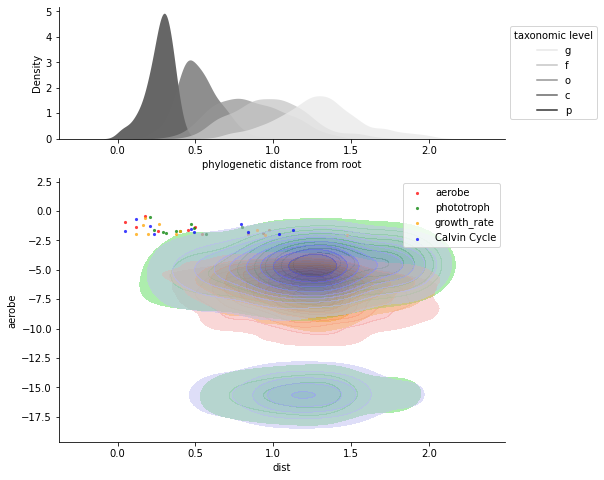

In [70]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(2, 1, height_ratios=[1,2])

ax_hist = fig.add_subplot(gs[0, 0])

sns.kdeplot(ax = ax_hist,
    data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')], 
            x='dist', hue='level', 
            common_norm=False, fill=True,
            linewidth=0, alpha=0.75, palette='Grays', 
            hue_order=['p', 'c', 'o', 'f', 'g'][::-1])

# manually construct legend
handles, labels = [], []
for hue_label, color in zip(['p', 'c', 'o', 'f', 'g'][::-1], 
                             sns.color_palette('Grays', n_colors=5)):
    handles.append(mpl.lines.Line2D([0], [0], color=color))
    labels.append(hue_label)

lgd = ax_hist.legend(handles, labels, title='taxonomic level',
                     loc='center left', bbox_to_anchor=(1, 0.5))

# ax_hist.set_xlim(-0.25, xmax)
ax_hist.set_xlabel('phylogenetic distance from root')
sns.despine()

ax = fig.add_subplot(gs[1, 0], sharex=ax_hist)

hue_series = pd.Series(index=varexp_ind_df.index, 
                       data=varexp_ind_df.index.isin(varexp_ind_df['aerobe'].sort_values().tail(10).index))
trait = 'aerobe'
color='blue'
n = 10
for trait, color in zip(['aerobe', 'phototroph', 'growth_rate', 'Calvin Cycle', ],
                        ['red', 'green', 'orange', 'blue']):
    # plot kde for aerobes
    sns.kdeplot(x=taxon_dist_df['dist'],
                    y=varexp_ind_df[trait].apply(np.log10),
                    legend=False, linewidth=0, alpha=0.5, color=color, fill=True, label=trait)

    # plot top 10 points
    n_largest = varexp_ind_df[trait].sort_values().tail(n).index
    x = pd.Series(index=varexp_ind_df[trait].sort_values().tail(n).index,
                  data=[gtdb_pruned.get_distance(gtdb_pruned.search_nodes(name=node)[0]) for node in n_largest])

    sns.scatterplot(x=x, y=varexp_ind_df[trait].apply(np.log10), 
                    label=trait, color=color, s=10, alpha=0.75, linewidth=0)

sns.despine()

In [586]:
%%time

precomputed_dists = []
n = 10000
unique_indices = set(i  for col in ['aerobe', 
                                    'phototroph', 
                                    'growth_rate', 
                                    'Calvin Cycle', 
                                    'gc_percentage', 
                                    'genome_size']  for i in varexp_ind_df[col].nlargest(n).index)

# unique_indices = sorted(set.union(*top_indices))

precomputed_dists = pd.Series(index=unique_indices,
                  data=[gtdb_pruned.get_distance(gtdb_pruned.search_nodes(name=node)[0]) for node in unique_indices])
    

CPU times: user 1h 1min 56s, sys: 1.2 s, total: 1h 1min 57s
Wall time: 1h 1min 58s


aerobe
phototroph
growth_rate
Calvin Cycle
gc_percentage
genome_size


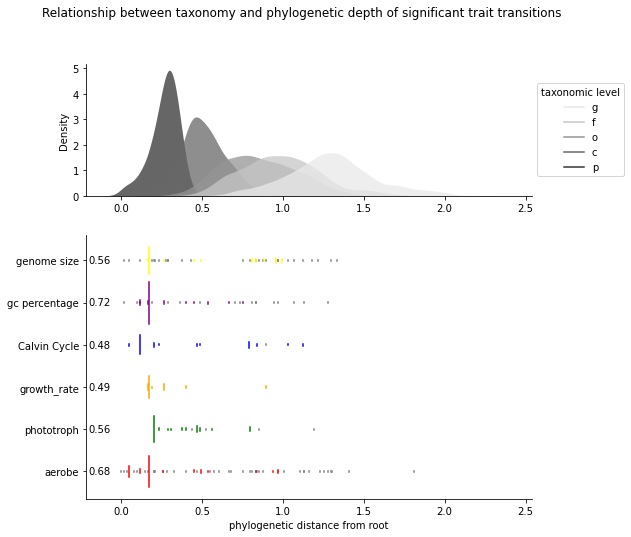

In [592]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(2, 1, height_ratios=[1,2])

ax_hist = fig.add_subplot(gs[0, 0])

sns.kdeplot(ax = ax_hist,
    data=taxon_dist_df[~taxon_dist_df['level'].eq('n_largest')].sort_values('level'), 
            x='dist', hue='level', 
            common_norm=False, fill=True,
            linewidth=0, alpha=0.75, palette='Grays', 
            hue_order=['p', 'c', 'o', 'f', 'g'][::-1])

# manually construct legend
handles, labels = [], []
for hue_label, color in zip(['p', 'c', 'o', 'f', 'g'][::-1], 
                             sns.color_palette('Grays', n_colors=5)):
    handles.append(mpl.lines.Line2D([0], [0], color=color))
    labels.append(hue_label)

lgd = ax_hist.legend(handles, labels, title='taxonomic level',
                     loc='center left', bbox_to_anchor=(1, 0.5))

# ax_hist.set_xlim(-0.25, xmax)
ax_hist.set_xlabel('')
sns.despine()

ax = fig.add_subplot(gs[1, 0], sharex=ax_hist)

hue_series = pd.Series(index=varexp_ind_df.index, 
                       data=varexp_ind_df.index.isin(varexp_ind_df['aerobe'].sort_values().tail(10).index))
trait = 'aerobe'
color='blue'
n = 1000
for trait, color, i in zip(['aerobe', 'phototroph', 'growth_rate', 'Calvin Cycle', 'gc_percentage', 'genome_size'],
                        ['red', 'green', 'orange', 'blue', 'purple', 'yellow'],
                          range(6)):
    print(trait)

    # plot top 10 points
    ten_largest = varexp_ind_df[trait].sort_values().tail(10)
    
    n_largest = varexp_ind_df[trait].sort_values().tail(n).index
    x = pd.Series(index=varexp_ind_df[trait].sort_values().tail(n).index,
                  data=precomputed_dists.loc[varexp_ind_df[trait].sort_values().tail(n).index].values)

    ax.annotate(f'{ten_largest.sum():.2f}', (-0.2, i), va='center', ha='left')
    
    
    for index, _x in x.items():
        temp_color = color
        wavelet = varexp_ind_df.loc[index, trait]
        if not index in ten_largest.index:
            temp_color = 'gray'
            
        plt.plot((_x, _x), (i + wavelet, i - wavelet), color=temp_color)
        
ax.set_yticks(list(range(6)))     
ax.set_yticklabels(['aerobe', 'phototroph', 'growth_rate', 'Calvin Cycle', 'gc percentage', 'genome size'])
    # sns.scatterplot(x=x, y=varexp_ind_df[trait].apply(np.log10), 
    #                 label=trait, color=color, s=10, alpha=0.75, linewidth=0)
ax.set_xlabel('phylogenetic distance from root')

sns.despine()

fig.suptitle('Relationship between taxonomy and phylogenetic depth of significant trait transitions')

plt.savefig('./../figures/haar_method/top_n_wavelet_dists.png', 
            bbox_inches='tight',
            dpi=400)

plt.savefig('./../figures/haar_method/top_n_wavelet_dists.svg', 
            bbox_inches='tight')

In [575]:
index

'c000130'

In [574]:
ten_largest

Index(['c008582', 'c000601', 'c002310', 'c000450', 'c004640', 'c001580',
       'c008942', 'c029142', 'c004648', 'c000130'],
      dtype='object')

In [636]:
taxon_dist_df['dist'].reindex(varexp_ind_df['aerobe'].sort_values().index)

c122752        NaN
c120784        NaN
c122400        NaN
c077719        NaN
c047308        NaN
            ...   
c030369    0.96989
c008582        NaN
c000302        NaN
c000028        NaN
c000130        NaN
Name: dist, Length: 50744, dtype: float64

In [609]:
taxon_dist_df

dist                             0 level
c000000  0.00000                   d__Bacteria     d
c000001  0.03779         96.0:p__Spirochaetota     p
c000021  0.34605  100.0:c__UBA4802; o__UBA4802     c
c000022  0.25938          100.0:c__Leptospirae     c
c000178  0.11634      86.0:p__Campylobacterota     p
...          ...                           ...   ...
c123843  2.07070       100.0:g__Antarctobacter     g
c123939  2.00749    100.0:g__Pseudophaeobacter     g
c123940  2.01227           100.0:g__Leisingera     g
c123941  2.01209  100.0:g__Pseudophaeobacter_A     g
c123942  1.99950          98.0:g__Epibacterium     g

[6532 rows x 3 columns]

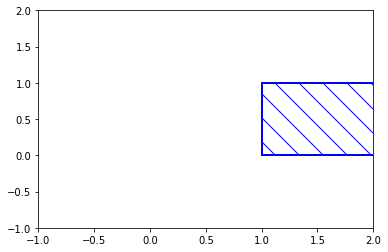

In [226]:


# Define the polygon vertices
xmin, xmax, ymin, ymax = 1, 10, 0, 1

# Create the plot
fig, ax = plt.subplots()

vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
# Plot the polygon with a hatch pattern
polygon = plt.Polygon(vertices, edgecolor='blue', facecolor='none', hatch='\\', linewidth=2)
ax.add_patch(polygon)

# Set axis limits and equal aspect ratio
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
# ax.set_aspect('equal')

# Show the plot
plt.show()


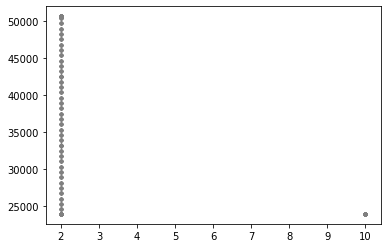

In [158]:
plt.scatter(x=X_rot, y=Y_rot, zorder=0, color='gray', s=5)

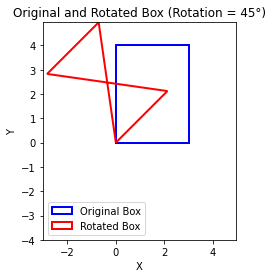

In [163]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_new_box(W, H, D_deg):
    # Convert degree to radians
    D_rad = np.radians(D_deg)
    
    # Rotation matrix
    R = np.array([[np.cos(D_rad), -np.sin(D_rad)],
                  [np.sin(D_rad), np.cos(D_rad)]])
    
    # Original corners of the box
    corners = np.array([[0, 0], [W, 0], [0, H], [W, H]])
    
    # Rotate corners
    rotated_corners = np.dot(corners, R.T)
    
    # Find new bounding box dimensions
    x_min = np.min(rotated_corners[:, 0])
    x_max = np.max(rotated_corners[:, 0])
    y_min = np.min(rotated_corners[:, 1])
    y_max = np.max(rotated_corners[:, 1])
    
    W_new = x_max - x_min
    H_new = y_max - y_min
    
    return W_new, H_new, rotated_corners

def plot_boxes(W, H, D_deg):
    # Calculate the new box dimensions and rotated corners
    W_new, H_new, rotated_corners = calculate_new_box(W, H, D_deg)
    
    # Plot the original box
    fig, ax = plt.subplots()
    original_box = plt.Rectangle((0, 0), W, H, linewidth=2, edgecolor='blue', facecolor='none', label='Original Box')
    ax.add_patch(original_box)
    
    # Plot the rotated box
    rotated_box = plt.Polygon(rotated_corners, closed=True, linewidth=2, edgecolor='red', facecolor='none', label='Rotated Box')
    ax.add_patch(rotated_box)
    
    # Set limits and aspect
    ax.set_xlim(-W, W_new)
    ax.set_ylim(-H, H_new)
    ax.set_aspect('equal', adjustable='box')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Original and Rotated Box (Rotation = {D_deg}°)')
    
    # Display the plot with legend
    plt.legend()
    plt.show()

# Example: plot the boxes for W=3, H=4, and D=45 degrees
plot_boxes(3, 4, 45)


In [138]:
set(X_rot)

{1.0, 10.0}

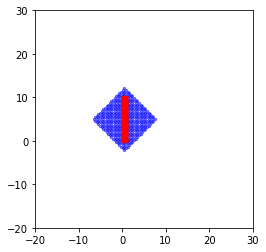

In [183]:
# Define the bounds and density parameter
xmin, xmax, ymin, ymax = 0, 1, 0, 10
density = 20  # Higher value means denser grid

def make_grid(xmin, xmax, ymin, ymax, density):

    # Create a larger grid before rotation (larger than the final bounds to account for rotation)
    # Calculate the center of the box
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    
    # Generate the grid around the center
    half_x = (xmax - xmin) / 2 # * np.sqrt(2)
    half_y = (ymax - ymin) / 2 # * np.sqrt(2)
    half_max = np.max([half_x, half_y])
    x = np.linspace(x_center - half_max, 
                    x_center + half_max, density)
    y = np.linspace(y_center - half_max, 
                    y_center + half_max, density)

    # Create meshgrid for the larger grid
    X, Y = np.meshgrid(x, y)

    # Flatten the meshgrid to get the coordinates
    X = X.flatten()
    Y = Y.flatten()
    
    return X, Y

def rotate_grid(X, Y, angle, xmin, xmax, ymin, ymax):
    # Calculate the center of the grid
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2

    # Translate the grid to the origin
    X_shifted = X - x_center
    Y_shifted = Y - y_center

    # Apply rotation by the given angle (rotation matrix)
    theta = np.radians(angle)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Apply rotation to all points
    rotated_coords = np.dot(rotation_matrix, np.vstack([X_shifted, Y_shifted]))

    # Get the rotated X and Y coordinates
    X_rot, Y_rot = rotated_coords[0], rotated_coords[1]

    # Translate the grid back to the original position
    X_rot += x_center
    Y_rot += y_center
    
    return X_rot, Y_rot

X, Y = make_grid(xmin, xmax, ymin, ymax, density)
X_rot, Y_rot = rotate_grid(X, Y, 45, xmin, xmax, ymin, ymax)

# Randomly scale densities of points in the grid
scales = np.random.uniform(10, 100, size=X_rot.shape)

# Plot the rotated grid with varying densities (point sizes)
_X, _Y = np.meshgrid(np.linspace(xmin, xmax, density),
            np.linspace(ymin, ymax, density))
plt.scatter(_X.flatten(), _Y.flatten(), s=5, alpha=0.5, color='red', zorder=1)
plt.scatter(X_rot, Y_rot, s=5, alpha=0.5, color='blue', zorder=0)
plt.xlim(-20, 30)
plt.ylim(-20, 30)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [83]:
set([type(x) for x in new_x])

{float}

In [88]:
np.isnan(new_x.astype(float)).sum()

150000

In [84]:
np.isnan(new_x)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

divide by zero encountered in log10
invalid value encountered in log10


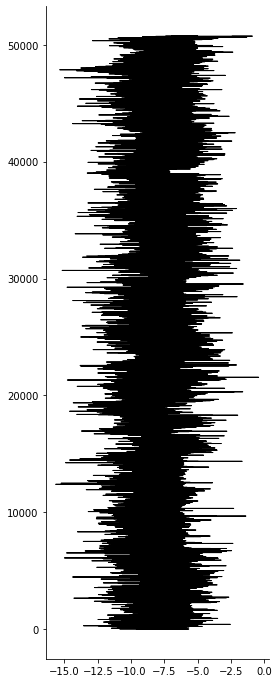

In [90]:
fig, ax = plt.subplots(figsize=(4,12))
plt.plot(np.log10(new_x), new_y, color='k', linewidth=1)
# ax.set_ylim(0, 5)
# ax.set_xlim(-0.01, 0.01)
sns.despine()

In [91]:
new_x

array([4.61069281e-08, 9.38644218e-09, 1.60897498e-07, ...,
       1.23671379e-01, 8.51273446e-03, 3.85714594e-03])

In [68]:
problematic_elements = [item for item in new_x if not isinstance(item, (int, float))]


In [73]:
import numpy as np

data = ["text", "42", np.nan, "another string", "3.14", 3.14]

filtered_data = []
for item in new_x:
    try:
        filtered_data.append(float(item))
    except (ValueError, TypeError):
        pass

numeric_array = np.array(filtered_data, dtype=float) if filtered_data else np.array([])

nan_mask = np.isnan(numeric_array)

print("Filtered numeric array:", numeric_array)
print("NaN mask:", nan_mask)


Filtered numeric array: [4.61069281e-08 9.38644218e-09 1.60897498e-07 ... 1.23671379e-01
 8.51273446e-03 3.85714594e-03]
NaN mask: [False False False ... False False False]


In [74]:
np.sum(nan_mask)

150000

In [81]:
new_x[nan_mask][0]

float

In [71]:
np.isnan(new_x)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [72]:
for item in new_x:
    try:
        np.isnan(item)
    except TypeError:
        print([item])

In [61]:
new_x

array([4.610692805329109e-08, 9.386442179071253e-09,
       1.608974978806188e-07, ..., 0.123671379400807, 0.008512734456721,
       0.0038571459435148], dtype=object)

## Trying to imporve this plot

In [28]:
import matplotlib.patheffects as pe


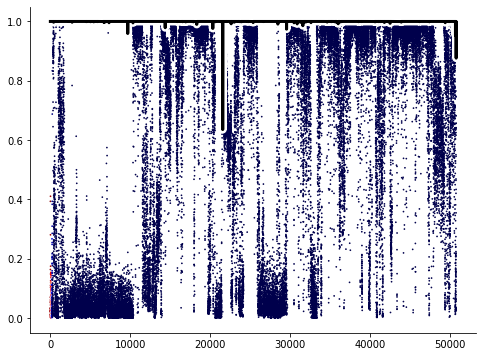

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
cmap = matplotlib.colormaps['seismic_r']

# colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]
colors = [to_hex(cmap(leaf_locs.loc[i])) for i in postorder_leaves]
y = pca_data.reindex(postorder_leaves)['aerobe'].values
x = list(range(len(postorder_leaves)))


ax.scatter(x, y,
           s=0.5,
           c=colors, zorder=0)

y1 = varexp_ind_df.reindex(postorder_nodes)['aerobe'].values
# x = np.log10(x)
x1 = range(len(y1))

line, = ax.plot(x1, 1 - y1, color='k', linewidth=3, zorder=2)
line.set_path_effects([pe.withStroke(linewidth=8, foreground='white')])
sns.despine()

In [31]:
def compute_loc(node, locs):
    if node.is_leaf():
        return locs.loc[node.name]
    else:
        children = node.get_children()
        ly = compute_loc(children[0], locs)
        lr = compute_loc(children[1], locs)
        
        return (ly + lr) / 2


In [32]:
leaf_locs = pd.Series(index=postorder_leaves,
                      data=list(range(1, len(postorder_leaves)+1)))

In [ ]:
for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    xmin = treeplot_xs[i][0]
    xmax = len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color='blue')
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='blue', facecolor='white', hatch='/'*xmin, 
                          linewidth=2)
    ax.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax.add_patch(polygon)
    
    # plot right
    xmin = treeplot_xs[i+1][0]
    xmax = len(ten_largest)
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor='blue', facecolor='white', hatch='\\'*xmin, linewidth=2)
    ax.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor='white', fill=False, 
                          linewidth=2)
    ax.add_patch(polygon)

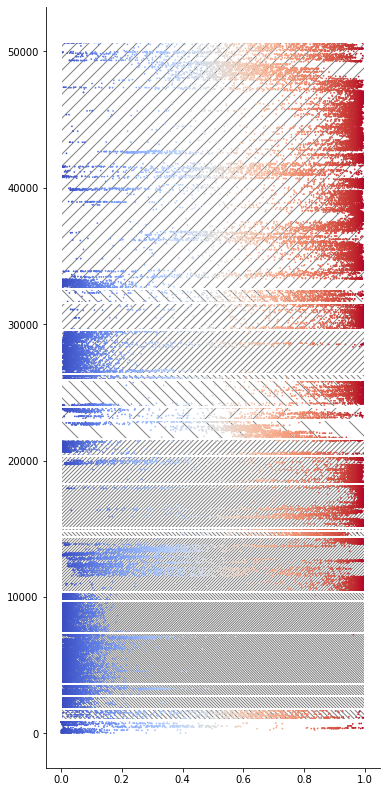

In [340]:
fig, ax = plt.subplots(figsize=(6,14))

treestruct_color = 'gray'
boxcolor = 'white'
ax.set_facecolor('white')

for i in range(0, len(treeplot_xs), 2):
    
    # for largest in ten_largest.index:
    #     ax.axhline(node_xlocs.loc[largest], color='white') #, linestyle=(0, (5, 10)))
    
    # plot left
    # xmin = (treeplot_xs[i][0]-1) / 10
    xmin =  0
    xmax = (len(ten_largest)) / 10
    # print(xmin, xmax)
    ymin = treeplot_ys[i][0]
    ymax = treeplot_ys[i][1]
    # print(ymin, ymax)
    
    plt.plot((xmin, xmax), (ymin, ymin), color=treestruct_color)
    
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor=treestruct_color, facecolor='white', hatch='/'*(int((treeplot_xs[i+1][0]-1))+1), 
                          linewidth=2, fill=True)
    ax.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor=boxcolor, fill=False, 
                          linewidth=2, zorder=2)
    ax.add_patch(polygon)
    
    # plot right
    # xmin = (treeplot_xs[i+1][0]-1) / 10
    xmin = 0
    xmax = (len(ten_largest)) / 10
    # print(xmin, xmax)
    ymin = treeplot_ys[i+1][0]
    ymax = treeplot_ys[i+1][1]
    # print(ymin, ymax)
    vertices = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    # Plot the polygon with a hatch pattern
    polygon = plt.Polygon(vertices, edgecolor=treestruct_color, facecolor='white', hatch='\\'*(int((treeplot_xs[i+1][0]-1))+1), 
                          linewidth=2, fill=True)
    ax.add_patch(polygon)
    polygon = plt.Polygon(vertices, edgecolor=boxcolor, fill=False, 
                          linewidth=2,zorder=2)
    ax.add_patch(polygon)


cmap = matplotlib.colormaps['coolwarm']

colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]
# colors = [to_hex(cmap(leaf_locs.loc[i] / len(leaf_locs))) for i in postorder_leaves]
y = pca_data.reindex(postorder_leaves)['aerobe'].values
x = list(range(len(postorder_leaves)))

ax.scatter(y, x,
           s=0.5,
           c=colors, zorder=1)

y1 = varexp_ind_df.reindex(node_xlocs.sort_values().index)['aerobe'].values
# x = nnode_xlocs * len(node_xlocs)p.log10(x)
x1 = node_xlocs.sort_values()

# line, = ax.plot(x1, 1 - y1, color='k', linewidth=3, zorder=2)
# line.set_path_effects([pe.withStroke(linewidth=8, foreground='white')])


sns.despine()

### Function definitions

In [35]:
def get_node_levels(tree, node_names):
    """
    Get the level (distance from root) of a set of nodes in a tree.

    Args:
    - tree: An ete3 Tree object.
    - node_names: A list of node names to find levels for.

    Returns:
    - A dictionary where keys are node names and values are their levels in the tree.
    """
    # Initialize result dictionary
    node_levels = {}

    # Traverse the tree using post-order traversal
    for node in tree.traverse("postorder"):
        if node.name in node_names:
            # Compute level as the distance from the root
            level = len(node.get_ancestors())
            node_levels[node.name] = level

    return node_levels

def find_repeated_segments(X, P, N=None):
    """
    Find start and stop indices of segments where the item P is repeated in X.

    Args:
    - X: List to search through.
    - P: The item to search for.
    - N: (Optional) Number of consecutive repetitions of P. If None, detects any repeated segment of P.

    Returns:
    - A DataFrame with columns 'start' and 'stop' indicating the indices of segments.
    """
    result = []
    count = 0
    start = None
    
    for i, item in enumerate(X):
        if item == P:
            count += 1
            if count == 1:
                start = i  # Mark the start of a potential segment
            if N is not None and count == N:
                result.append(np.array([start, i]))
                count = 0  # Reset for next sequence
        else:
            if N is None and count > 1:  # For any repeated segment, save the segment
                result.append(np.array([start, i - 1]))
            count = 0
            start = None  # Reset start

    # Handle case where the sequence ends with a segment
    if count > 0:
        result.append(np.array([start, len(X) - 1]))

    
    return pd.DataFrame(result).rename(columns={0: 'start', 1: 'stop'})

    


In [36]:
# define collapsing function
# if there are no wavelets in the subtree
# construct collapsing method
def collapseTree(tree, func, **collapse_args): 
    '''
    Master TreeNode collapsing function
    Collapses a TreeNode using specified leaf finding function
    '''
    # collapse tree using function
    t = Tree(tree.write(is_leaf_fn=lambda n: func(n, **collapse_args), format=3),format=3) 
    t.name = tree.name
    return t

def collapse_to_wavelets(node, wavelet_clades):
    '''
    collapses to phylum root nodes
    '''
    if node.is_leaf():
        return True
    elif node.up is None:
        return False
    else:
        return all([not n.name in wavelet_clades for n in node.traverse(strategy='levelorder')])

In [41]:
top10_wavelets = varexp_ind_df.sort_values('aerobe', ascending=False).head(10).index

In [42]:
wavelet_tree = collapseTree(gtdb_pruned, collapse_to_wavelets, wavelet_clades=list(set(top10_wavelets).union(top_phyla_clades.index)))
wavelet_tree.describe()

Number of leaf nodes:	86
Total number of nodes:	171
Rooted:	Yes
Most distant node:	c033016
Max. distance:	1.038860


In [43]:
wavelet_leaf_series = pd.Series(dict((n.name, get_leaf_names(gtdb_pruned.search_nodes(name=n.name)[0])) for n in wavelet_tree.get_leaves()))

In [44]:
wavelet_leaf_series = wavelet_leaf_series.explode()

In [45]:
reordered = pd.Series(wavelet_leaf_series.index, index=wavelet_leaf_series).reindex(postorder_leaves)

In [46]:
space = 10

In [47]:
target_node = 'c014430'

In [48]:
largest_left = get_leaf_names(gtdb_pruned.search_nodes(name=target_node)[0].get_children()[0])
largest_right = get_leaf_names(gtdb_pruned.search_nodes(name=target_node)[0].get_children()[1])

### Plot 1: wavelets superimposed

11493.5 10618.5 12576.5
CPU times: user 4.92 s, sys: 219 ms, total: 5.14 s
Wall time: 4.92 s


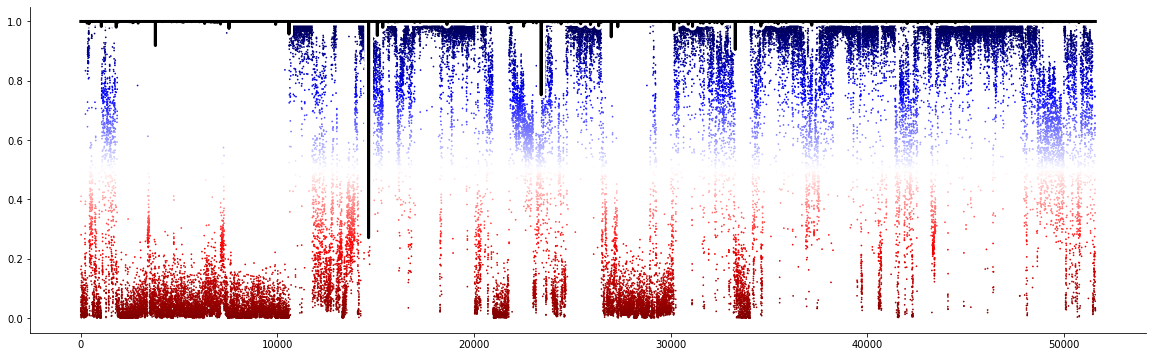

In [49]:
%%time

fig, ax = plt.subplots(figsize=(20,6))
cmap = matplotlib.colormaps['seismic_r']

colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]
# colors = [to_hex(cmap(leaf_locs.loc[i])) for i in postorder_leaves]
y = pca_data.reindex(postorder_leaves)['aerobe'].values
x = list(range(len(postorder_leaves)))

new_x, new_y, new_c, new_porder = tuple([spacify_data(labels=reordered.values,
                                           arr=a,
                                           space_size=space, insert_val=iv) for a, iv in zip([x, y, colors, postorder_leaves],
                                                                                             [np.nan, np.nan, 'gray', 'None'])])

# need to add new_x = range(len(new_y)), I think
new_x = np.array(range(len(new_y)))
# colors = np.array(['yellow' if new_porder[i] in largest_left else 'blue' if new_porder[i] in largest_right else 'gray' for i in range(len(new_x))])

ax.scatter(new_x, new_y,
            # new_x[colors != 'gray'], new_y[colors != 'gray'],
           s=0.5,
           c=new_c,
           # c=colors[colors != 'gray'],
           # c=[new_c[i] if new_porder[i] in largest_left else 'gray' for i in range(len(new_x))], 
           zorder=0)



y1 = varexp_ind_df.reindex(node_xlocs.sort_values().index)['aerobe'].values
# x = nnode_xlocs * len(node_xlocs)p.log10(x)
x1 = node_xlocs.sort_values()
# ax.axvline(node_xlocs.loc[target_node], color='r')
# ax.axvline(node_xlocs.loc[gtdb_pruned.search_nodes(name=target_node)[0].get_children()[0].name], color='yellow')
# ax.axvline(node_xlocs.loc[gtdb_pruned.search_nodes(name=target_node)[0].get_children()[1].name], color='blue')

print(node_xlocs.loc[target_node],
        node_xlocs.loc[gtdb_pruned.search_nodes(name=target_node)[0].get_children()[0].name],
    node_xlocs.loc[gtdb_pruned.search_nodes(name=target_node)[0].get_children()[1].name])

new_x1, new_y1 = tuple([spacify_data(labels=reordered.values,
                                           arr=a,
                                           space_size=space, insert_val=iv) for a, iv in zip([x1, y1],
                                                                                             [np.nan, 0])])
new_x1 = list(range(len(new_y1)))

line, = ax.plot(new_x1, 1 - new_y1 * 2, color='k', linewidth=3, zorder=2)
line.set_path_effects([pe.withStroke(linewidth=8, foreground='white')])
sns.despine()

# test = spacify_data(labels=reordered.values, arr=x1, space_size=space, insert_val='blah')
# # draw a thin horizontal line at each clade boundary
# for index, item in find_repeated_segments(test, 'blah', space).mean(1).items():
#     # print(item, reordered.unique()[index])
#     ax.axvline(item, linewidth=1, color='gray')

# ax.set_xlim(10600, 12600)
# ax.set_ylim(0.95, 1)

In [50]:
def exaggerate_small_values(arr, scale=5, stretch=0.5):
    normalized = arr / np.max(arr)
    transformed = normalized ** stretch / (1 + scale * (1 - normalized ** stretch))
    return transformed * np.max(arr)


### Plot 2: wavelets superimposed with small values exaggerated

invalid value encountered in power


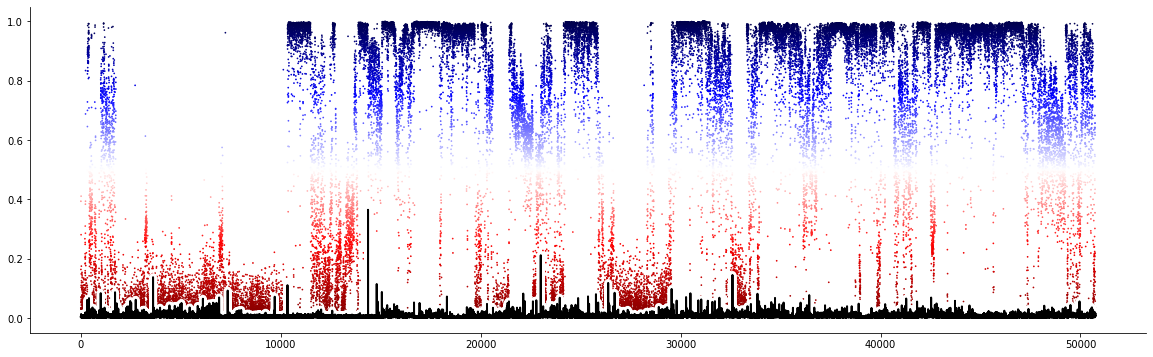

In [51]:
# plot scatter
fig, ax = plt.subplots(figsize=(20,6))

plt.scatter(list(range(len(y))), y,
            # new_x[colors != 'gray'], new_y[colors != 'gray'],
           s=0.5,
           c=colors,
           # c=colors[colors != 'gray'],
           # c=[new_c[i] if new_porder[i] in largest_left else 'gray' for i in range(len(new_x))], 
           zorder=0)

# plot lines
# spaced_x1 = 

line, = ax.plot(node_xlocs.sort_values(), 
                exaggerate_small_values(y1, scale=2, stretch=0.2), 
                color='k', linewidth=2, zorder=2)
line.set_path_effects([pe.withStroke(linewidth=8, foreground='white')])
sns.despine()

# for index, row in find_repeated_segments(spaced_c, 'gray').iterrows():
#     # print(item, reordered.unique()[index])
#     ax.axvline(row['start'], linewidth=1, color='gray')
#     ax.axvline(row['stop'], linewidth=1, color='gray')
#     print(row['stop'])
    
sns.despine()

# for node in top10_wavelets:
    # ax.axvline(new_xlocs.loc[node], color='green', linewidth=5, zorder=0)

In [52]:
def calculate_weights(start, end, w_start, w_end):
    """
    Calculate exponential weights for numbers between `start` and `end`.

    Args:
    - start (int): Start of the range (e.g., 1).
    - end (int): End of the range (e.g., 24).
    - w_start (float): Weight at the start of the range (e.g., 1).
    - w_end (float): Weight at the end of the range (e.g., 10,000).

    Returns:
    - List of weights for the range.
    """
    # Calculate b
    b = np.log(w_end / w_start) / (end - start)
    # Calculate a
    a = w_start / np.exp(b * start)
    # Generate weights
    weights = [a * np.exp(b * x) for x in range(start, end+1)]
    return weights

In [53]:
weights = pd.Series(index=np.linspace(1, 24, 24),
              data=calculate_weights(1, 24, 10, 10000))

<Axes: xlabel='None'>

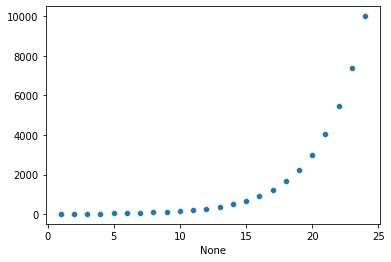

In [54]:
sns.scatterplot(x=weights.index, y=weights.values)

In [55]:
node_xlocs

c000000      410.5
c000001      320.5
c000014      995.5
c000003        9.5
c000010      331.5
            ...   
c124564    45520.5
c124566    43626.5
c124569    45126.5
c124572    45521.5
c124576    45127.5
Length: 50744, dtype: float64

### Plot 3: spacing around large nodes

In [56]:
def insert_xlocs(curr_xlocs, location, val, block_size):
    new_ind = list(curr_xlocs.index) + [val] * block_size 
    new_data = list(curr_xlocs.apply(lambda x: x + block_size if x > location else x).values) + list(range(int(location)+1, int(location)+block_size+1))
    return pd.Series(index=new_ind, data=new_data)

def make_index_unique(series):
    seen = {}
    new_index = []
    for idx in series.index:
        if idx in seen:
            random_suffix = ''.join(random.choices(string.ascii_letters + string.digits, k=6))
            new_idx = f"{idx}_{random_suffix}"
            seen[idx] += 1
        else:
            new_idx = idx
            seen[idx] = 1
        new_index.append(new_idx)
    series.index = new_index
    return series

In [57]:
import random, string

In [58]:
node_levels = pd.Series(get_node_levels(wavelet_tree, [l.name for l in wavelet_tree.traverse()]))

In [59]:
node_levels.sort_values()

c000000     0
c000001     1
c000014     1
c000028     2
c000027     2
           ..
c027849    21
c030370    22
c030369    22
c033015    23
c033016    23
Length: 171, dtype: int64

In [60]:
top10_wavelets

Index(['c000130', 'c000028', 'c000302', 'c008582', 'c030369', 'c000601',
       'c000592', 'c027850', 'c010372', 'c002137'],
      dtype='object')

In [61]:
# increase space at major clade boundaries
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]
y = pca_data.reindex(postorder_leaves)['aerobe'].values
y1 = varexp_ind_df.reindex(node_xlocs.sort_values().index)['aerobe'].values



In [62]:
spaced_c = colors.copy()
spaced_y = y.copy()
spaced_y1 = y1.copy()

new_xlocs = node_xlocs.copy(deep=True)

# first, test
print('test')
block_locs = find_repeated_segments(new_xlocs.index, 'blah')
print(block_locs)

num_added = 5000

# while index < len(reordered.unique()):
# nodes = ['c000028']
for node in node_levels.reindex(index=top10_wavelets).sort_values().index:
    num_added = weights.loc[24 - node_levels.loc[node]]
    
    print('First block, from here:', new_xlocs.loc[node] - int(num_added / 2)-1,
         'to here', new_xlocs.loc[node] - int(np.round(num_added / 2)) -1 + int(num_added / 2))
    
    new_xlocs = insert_xlocs(new_xlocs, 
                             new_xlocs.loc[node]-1, 
                             'blah', 
                             int(num_added / 2))
    
    new_xlocs = insert_xlocs(new_xlocs, 
                             new_xlocs.loc[node]+1, 
                             'blah', 
                             int(num_added / 2))
    
    # current locations of all inserted blocks
    block_locs = find_repeated_segments(new_xlocs.sort_values().index, 'blah')
    print(block_locs)
    
    
    for block in [0, 1]:
        # location at which to insert
        current_block = int(block_locs.loc[block, 'start'])

        # size of insert
        # num_added = int(weights.loc[node_levels.loc[reordered.unique()[index], 'level']])

        # perform insertion
        spaced_y = np.insert(spaced_y, current_block, [np.nan] * (int(num_added / 2)))

        # if index < len(reordered.unique())-1:
        spaced_y1 = np.insert(spaced_y1, current_block, [0] * (int(num_added / 2)))

        spaced_c = np.insert(spaced_c, current_block, ['gray'] * (int(num_added / 2)))

    #uniqueify new_xlocs
    new_xlocs = make_index_unique(new_xlocs)

    
    # index += 1

test
Empty DataFrame
Columns: []
Index: []
First block, from here: 20262.5 to here 23004.5
   start   stop
0  23004  25745
1  25748  28489
First block, from here: 13252.5 to here 14364.5
   start   stop
0  14365  15477
1  15480  16592
First block, from here: 39190.5 to here 40302.5
   start   stop
0  40303  41415
1  41418  42530
First block, from here: 9884.5 to here 10336.5
   start   stop
0  10336  10787
1  10790  11241
First block, from here: 17594.5 to here 17929.5
   start   stop
0  17929  18263
1  18266  18600
First block, from here: 18756.5 to here 18855.5
   start   stop
0  18856  18955
1  18958  19057
First block, from here: 3572.5 to here 3611.5
   start  stop
0   3612  3651
1   3654  3693
First block, from here: 7395.5 to here 7425.5
   start  stop
0   7425  7454
1   7457  7486
First block, from here: 39164.5 to here 39173.5
   start   stop
0  39173  39181
1  39184  39192
First block, from here: 35994.5 to here 35999.5
   start   stop
0  36000  36005
1  36008  36013


In [63]:
def exaggerate_small_values(arr, scale=5, stretch=0.5):
    normalized = arr / np.max(arr)
    transformed = normalized ** stretch / (1 + scale * (1 - normalized ** stretch))
    return transformed * np.max(arr)


invalid value encountered in power


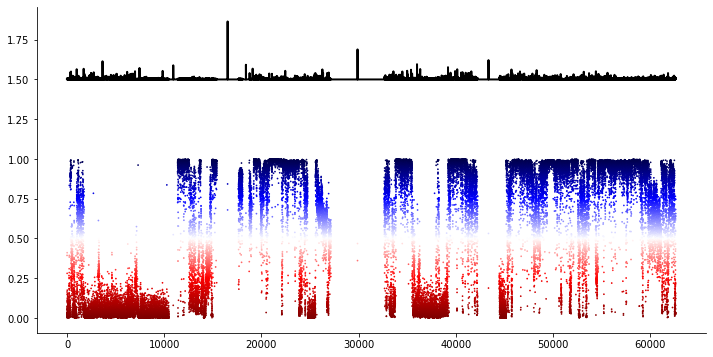

In [150]:
# plot scatter
fig, ax = plt.subplots(figsize=(12,6))

plt.scatter(list(range(len(spaced_y))), spaced_y,
            # new_x[colors != 'gray'], new_y[colors != 'gray'],
           s=0.5,
           c=spaced_c,
           # c=colors[colors != 'gray'],
           # c=[new_c[i] if new_porder[i] in largest_left else 'gray' for i in range(len(new_x))], 
           zorder=0)

# plot lines
spaced_x1 = new_xlocs.sort_values()

line, = ax.plot(spaced_x1, 1.5 + exaggerate_small_values(spaced_y1, scale=2, stretch=0.25), color='k', linewidth=2, zorder=2)
# line.set_path_effects([pe.withStroke(linewidth=8, foreground='white')])
sns.despine()

# for index, row in find_repeated_segments(spaced_c, 'gray').iterrows():
#     # print(item, reordered.unique()[index])
#     ax.axvline(row['start'], linewidth=1, color='gray')
#     ax.axvline(row['stop'], linewidth=1, color='gray')
#     print(row['stop'])
    
sns.despine()

# for node in top10_wavelets:
    # ax.axvline(new_xlocs.loc[node], color='green', linewidth=5, zorder=0)
    
# plt.savefig('./../figures/summary_fig_test.png', dpi=300, bbox_inches='tight')

### Plot 4: testing alternate visualization method 

In [37]:
target_node

NameError: name 'target_node' is not defined

In [65]:
test_leaves = get_leaf_names(gtdb_pruned.search_nodes(name=target_node)[0])

In [151]:
x1, y1

test


In [38]:
def average_hex_color(hex_colors):
    """
    Calculates the average color from a list of hex color strings.
    """

    rgb_values = [
        [int(hex_color[i:i + 2], 16) for i in range(1, 7, 2)]
        for hex_color in hex_colors
    ]

    avg_rgb = [
        sum(color[i] for color in rgb_values) // len(rgb_values)
        for i in range(3)
    ]

    return f"#{''.join(f'{value:02x}' for value in avg_rgb)}"


In [39]:
xvals = pd.Series(index=postorder_leaves,
                     data=range(len(postorder_leaves)))

colors = np.array(colors)


In [41]:
%%time
average_colors = pd.Series()
for i, node in enumerate(gtdb_pruned.traverse()):
    if i % 100 ==0:
        display(i)
        clear_output(wait=True)
    leaves = get_leaf_names(node)
    average_colors.loc[node.name] = average_hex_color(colors[xvals.loc[leaves]])

CPU times: user 12min 1s, sys: 1.22 s, total: 12min 2s
Wall time: 12min 1s


In [46]:
%%time
# fig, ax = plt.subplots(figsize=(20, 20))
xs = []
ys = []
cs = []

for node_po, node in enumerate(postorder_nodes[:500]):

    leaves = get_leaf_names(gtdb_pruned.search_nodes(name=node)[0])
    
    xs += [xvals.loc[leaves].min(), xvals.loc[leaves].max()]
    ys += [node_po] * 2
    cs += [average_colors.loc[node]] * 2
    # print(ys)
    # print(xs)
    # print()

CPU times: user 1min 9s, sys: 35.3 ms, total: 1min 9s
Wall time: 1min 9s


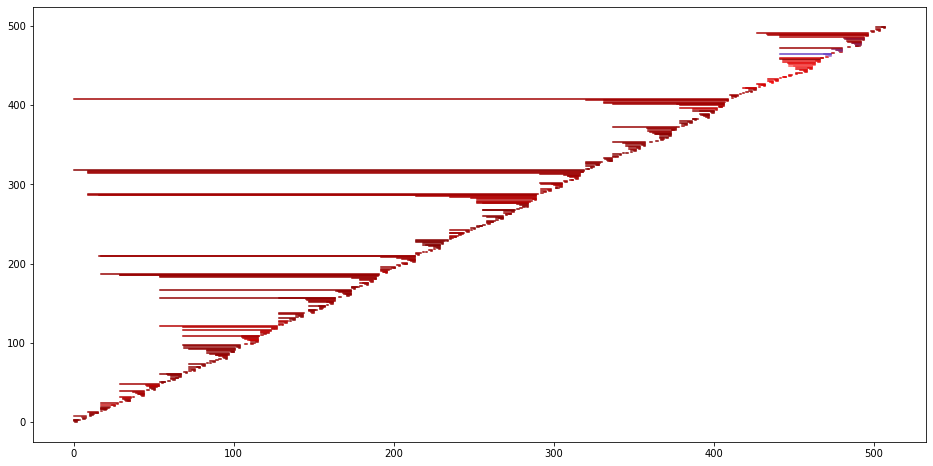

In [48]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(0, len(xs), 2):
    plt.plot(xs[i:i+2], ys[i:i+2], c=cs[i // 2])

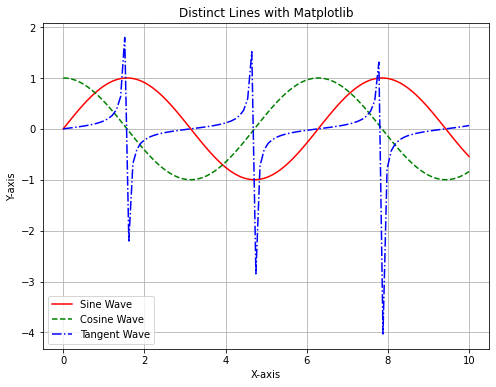

In [206]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0, 10, 100)
lines = [
    (x, np.sin(x), 'r-', 'Sine Wave'),    # Red solid line
    (x, np.cos(x), 'g--', 'Cosine Wave'), # Green dashed line
    (x, np.tan(x)/10, 'b-.', 'Tangent Wave') # Blue dash-dot line
]

# Plot each line with a distinct style
plt.figure(figsize=(8, 6))
for x, y, style, label in lines:
    plt.plot(x, y, style, label=label)

# Add labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Distinct Lines with Matplotlib")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [184]:
len(xvals.values)

50745

In [ ]:
plt.show()

In [157]:
colors

['#900000',
 '#8a0000',
 '#8c0000',
 '#8a0000',
 '#ff9191',
 '#d20000',
 '#840000',
 '#840000',
 '#8e0000',
 '#9a0000',
 '#900000',
 '#8a0000',
 '#9c0000',
 '#a30000',
 '#900000',
 '#ff1d1d',
 '#ffa5a5',
 '#a20000',
 '#900000',
 '#b30000',
 '#b80000',
 '#820000',
 '#cc0000',
 '#9e0000',
 '#840000',
 '#880000',
 '#960000',
 '#a00000',
 '#d80000',
 '#860000',
 '#8c0000',
 '#800000',
 '#800000',
 '#c00000',
 '#800000',
 '#820000',
 '#960000',
 '#820000',
 '#bc0000',
 '#8c0000',
 '#8c0000',
 '#8a0000',
 '#8c0000',
 '#9a0000',
 '#880000',
 '#8a0000',
 '#860000',
 '#800000',
 '#840000',
 '#880000',
 '#9e0000',
 '#9c0000',
 '#920000',
 '#8c0000',
 '#b00000',
 '#a60000',
 '#b00000',
 '#820000',
 '#b60000',
 '#ce0000',
 '#ca0000',
 '#a60000',
 '#a60000',
 '#b20000',
 '#a00000',
 '#ae0000',
 '#c80000',
 '#b30000',
 '#c30000',
 '#b60000',
 '#a30000',
 '#bc0000',
 '#880000',
 '#880000',
 '#8a0000',
 '#8a0000',
 '#8a0000',
 '#ac0000',
 '#960000',
 '#9e0000',
 '#9a0000',
 '#8a0000',
 '#9a0000',
 '#9

## draw a matching tree

In [71]:
names_map = pd.read_csv('./../finalized_data/gtdb_tree_names_map.tsv.gz', sep='\t', index_col=0)['0']
names_map

c000000                         d__Bacteria
c000001               96.0:p__Spirochaetota
c000002                                96.0
c000003                                97.0
c000004                                78.0
                              ...          
c124576                                46.0
RS_GCF_004114975_1       RS_GCF_004114975.1
RS_GCF_900115265_1       RS_GCF_900115265.1
RS_GCF_003601985_1       RS_GCF_003601985.1
RS_GCF_002879535_1       RS_GCF_002879535.1
Name: 0, Length: 124581, dtype: object

In [145]:
def collapse_tree_phylum(tree): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapse_to_phylum(n), format=3),format=3) 
    t.name = tree.name
    return t

def collapse_to_phylum(node):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    value = False
    leaf_value = False
    if node.is_leaf():
        leaf_value = True
        value = True
    else:
        if 'p__' in names_map.loc[node.name]:
            # print(node.name, names_map.loc[node.name])
            value = True
        else:
            value = False
    # print(node.name, value, leaf_value)
    return value

def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
#     if node.is_leaf():
#         # new_name = names_map.loc[node.name].split(':')[-1].split(';')[0].lstrip()
#         faces.add_face_to_node(TextFace(f" {node.name}", fsize=6), node, column=0, position='aligned')
#     else:
#         # new_name = names_map.loc[node.name].split(':')[-1].split(';')[0].lstrip()
#         faces.add_face_to_node(TextFace(f" {node.name}", fsize=6), node, column=0)
        
#         num_leaves = len(gtdb_full.search_nodes(name=node.name)[0].get_leaves())
#         faces.add_face_to_node(TextFace(f"{num_leaves}", fsize=6), node, column=1, position='aligned')
    
#         face_color='k'
#         if num_leaves >= 1900:
            
#             face_color='red'
            
#         # face_color = node_size_cmap(len(node.get_leaves()) / 2000)
#         R1 = RectFace(width=num_leaves / 100,
#                       height=3, 
#               fgcolor=face_color,
#               bgcolor=face_color)
#         faces.add_face_to_node(R1, node, 2, position='aligned')

        
        # internal_ns['fgcolor'] = face_color
    if node.name == 'c000130':
        internal_ns['size'] = 5
        internal_ns['fgcolor'] = 'red'
    if node.name == 'c000028':
        internal_ns['size'] = 5
        internal_ns['fgcolor'] = 'blue'
    node.img_style = internal_ns

ts = TreeStyle()
# ts.mode = 'c'
ts.layout_fn = layout_collapsed
# ts.scale=400
# ts.force_topology = True
ts.show_leaf_name = False
ts.draw_guiding_lines = True
ts.complete_branch_lines_when_necessary = True

In [142]:
test_wavelet_tree = collapseTree(gtdb_pruned, collapse_to_wavelets, wavelet_clades=top10_wavelets)

In [143]:
test_wavelet_tree.convert_to_ultrametric()


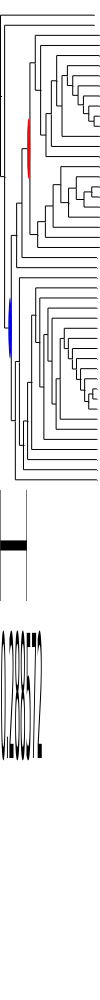

In [146]:
test_wavelet_tree.render('%%inline', tree_style=ts, w=100, h=1000)

In [122]:
node_xlocs.loc['c000001']

320.5

## End

done


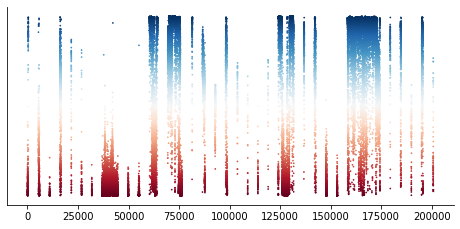

In [44]:
cmap = matplotlib.colormaps['RdBu']
# to generate plot identifying a single clade
# colors = [cmap(pca_data.loc[i, 'aerobe']) if i in test_leaves else 'gray' for i in postorder_leaves]
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2,1,1)

y = pca_data.reindex(postorder_leaves)['aerobe'].values
x = list(range(len(postorder_leaves)))

space = 5000

new_y, new_c, new_labels = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([y, colors, postorder_leaf_clades],
                                                                                                 [np.nan, 'gray', 'None'])])

new_x = range(len(new_y))

plt.scatter(new_x, new_y,
           s=0.5,
           c=new_c)

# temp = np.where(new_labels[:-1] != new_labels[1:])[0] + 1
# temp = [temp[i] for i in range(0, len(temp), 2)]

# for val in temp:
#     ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
# my_list_unique = set(phylum_postorder.index)
# first_index = pd.Series(dict((x, np.min(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
# last_index = pd.Series(dict((x, np.max(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
# label_loc = first_index + ((last_index - first_index) / 2).astype(int)

# for clade, yloc in label_loc.items():
#     ax.annotate(text=top_phyla_clades.loc[clade].split(';')[0].split('__')[-1], xytext=(-0.15, yloc),
#                              xy=(-0.05,yloc), arrowprops={'arrowstyle':'->'},
#                              annotation_clip=False, va='center', ha='right')
sns.despine()
plt.tick_params(left=False, labelleft=False)
print('done')

In [ ]:
cmap = matplotlib.colormaps['RdBu']
# to generate plot identifying a single clade
# colors = [cmap(pca_data.loc[i, 'aerobe']) if i in test_leaves else 'gray' for i in postorder_leaves]
colors = [to_hex(cmap(pca_data.loc[i, 'aerobe'])) for i in postorder_leaves]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2,1,1)

x = pca_data.reindex(postorder_leaves)['aerobe'].values
y = list(range(len(postorder_leaves)))

space = 5000

new_x, new_c, new_labels = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([x, colors, postorder_leaf_clades],
                                                                                                 [np.nan, 'gray', 'None'])])

new_y = range(len(new_x))

plt.scatter(new_x, new_y,
           s=0.5,
           c=new_c)

temp = np.where(new_labels[:-1] != new_labels[1:])[0] + 1
temp = [temp[i] for i in range(0, len(temp), 2)]

for val in temp:
    ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
my_list_unique = set(phylum_postorder.index)
first_index = pd.Series(dict((x, np.min(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
last_index = pd.Series(dict((x, np.max(np.nonzero(new_labels == x)[0])) for x in my_list_unique))
label_loc = first_index + ((last_index - first_index) / 2).astype(int)

for clade, yloc in label_loc.items():
    ax.annotate(text=top_phyla_clades.loc[clade].split(';')[0].split('__')[-1], xytext=(-0.15, yloc),
                             xy=(-0.05,yloc), arrowprops={'arrowstyle':'->'},
                             annotation_clip=False, va='center', ha='right')
sns.despine()
plt.tick_params(left=False, labelleft=False)
print('done')

## PART 2 ------------------------------------------------------------------------------------
ax1 = fig.add_subplot(1,2,2)
x = varexp_ind_df.reindex(postorder_nodes)['aerobe'].values
y = range(len(x))
print('step1')
new_x, new_y = tuple([spacify_data(labels=postorder_leaf_clades,
                                               arr=a,
                                               space_size=space, insert_val=iv) for a, iv in zip([x, y],
                                                                                                 [np.nan,  np.nan])])


## PART 3 ------------------------------------------------------------------------------------
print('step3')
plt.plot(new_x, new_y, color='k', linewidth=1)
    
for val in temp:
    ax.axhline(val+int(space / 2), linewidth=1, color='k')
    
sns.despine()
plt.tick_params(left=False, labelleft=False)

ax.spines['left'].set_visible(False)
ax1.spines['left'].set_visible(False)

In [38]:
varexp_ind_df

Unnamed: 0        aerobe    phototroph   3HP bicycle       3HP/4HB  \
0        c000130  3.646121e-01  5.283598e-03  2.107029e-04  4.430777e-05   
1        c000028  1.236714e-01  1.847801e-03  9.423194e-04  4.035584e-04   
2        c000302  4.718858e-02  1.499170e-04  2.160817e-03  7.851155e-04   
3        c008582  4.063921e-02  0.000000e+00  4.337631e-08  8.349768e-07   
4        c030369  2.597832e-02  4.580259e-03  0.000000e+00  0.000000e+00   
...          ...           ...           ...           ...           ...   
50739    c077719  2.220446e-16  0.000000e+00  0.000000e+00  0.000000e+00   
50740    c047308  4.440892e-16  0.000000e+00  0.000000e+00  0.000000e+00   
50741    c122400  0.000000e+00 -2.220446e-16  0.000000e+00  0.000000e+00   
50742    c122752 -2.220446e-16  2.220446e-16  0.000000e+00  0.000000e+00   
50743    c120784  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

       Calvin Cycle  rAcoA homoacetogenic        rTCA I       rTCA II  \
0      2.722736e-05              0.001272  4.839425e-05  2.094169e-03   
1      1.857765e-02              0.000182  1.197432e-04  1.711030e-03   
2      2.230438e-01              0.000189  1.004053e-04  8.337701e-03   
3      3.939495e-08              0.000001  0.000000e+00  3.375380e-07   
4      0.000000e+00              0.000000  4.675621e-07  3.945521e-07   
...             ...                   ...           ...           ...   
50739  0.000000e+00              0.000000  0.000000e+00  0.000000e+00   
50740  2.220446e-16              0.000000  0.000000e+00  0.000000e+00   
50741  0.000000e+00              0.000000  0.000000e+00  0.000000e+00   
50742  0.000000e+00              0.000000  0.000000e+00  0.000000e+00   
50743  0.000000e+00              0.000000  0.000000e+00  0.000000e+00   

        growth_rate   genome_size  gc_percentage  
0      2.605792e-01  3.122489e-01   4.970016e-01  
1      3.925120e-03  8.713255e-03   2.592307e-04  
2      1.060741e-02  4.226230e-03   6.790223e-02  
3      2.701496e-03  1.216700e-02   6.166228e-04  
4      1.326306e-04  4.148533e-03   8.333835e-04  
...             ...           ...            ...  
50739  1.279702e-07  1.737854e-07   4.840480e-07  
50740  1.636795e-07  1.421411e-07   1.902157e-10  
50741  7.728162e-06  6.261014e-11   2.262452e-08  
50742  3.852314e-05  9.419687e-12   8.148306e-10  
50743  2.540731e-07  3.813616e-13   2.944306e-09  

[50744 rows x 12 columns]